# Projet 4

In [ ]:
# Installation des librairies
# pip install pandas numpy matplotlib seaborn
# pip install openpyxl

In [ ]:
import sys # Python v3.12.4
import pandas as pd # v2.2.2
import numpy as np # v2.1.1
import matplotlib.pyplot as plt
import seaborn as sns # v0.13.2
import missingno as msno # 0.5.2

import sklearn as sk # 1.5.2
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Information sur l'environnement virtuel
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Seaborn       : " + sns.__version__)
print("missingno     : " + msno.__version__)
print("sklearn       : " + sk.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.2
NumPy         : 1.26.4
Seaborn       : 0.13.2
missingno     : 0.5.2
sklearn       : 1.5.2


## Importation des données

In [ ]:
data_test = pd.read_csv("application_test.csv")
data_train = pd.read_csv("application_train.csv")
data_bb = pd.read_csv("bureau_balance.csv")
data_bureau = pd.read_csv("bureau.csv")
data_ccb = pd.read_csv("credit_card_balance.csv")
# data_hccd = pd.read_csv("HomeCredit_columns_description.csv")
data_ip = pd.read_csv("installments_payments.csv")
data_pcb = pd.read_csv("POS_CASH_balance.csv")
data_app = pd.read_csv("previous_application.csv")
data_sample = pd.read_csv("sample_submission.csv")

### Fonctions

In [ ]:
def graph_stats(feature, label_rotation=False, horizontal_layout=True):
    temp = data_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index, "Nombres de Contrat": temp.values})

    cat_perc = data_train[[feature, "TARGET"]].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by="TARGET", ascending=False, inplace=True)

    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12, 14))

    sns.barplot(ax=ax1, x=feature, y="Nombres de Contrat", data=df1, hue=feature, palette="viridis", dodge=False)

    if(label_rotation):
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

    sns.barplot(ax=ax2, x=feature, y="TARGET", order=cat_perc[feature], data=cat_perc, hue=feature, palette="viridis", dodge=False)

    if(label_rotation):
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

    ax2.set_ylabel("Pourcentage pour une valeur TARGET '1' ", fontsize=10)
    ax2.tick_params(axis="both", which="major", labelsize=10)

    plt.show()

    return None

def plot_graph(data, title):
    plt.figure(figsize=(20, 8))
    ax = sns.countplot(y=data)
    ax.set_title(title)

    # Ajout des annotations pour afficher les pourcentages
    total = len(data)
    for p in ax.patches:
        percentage = f'{100 * p.get_width() / total:.1f}%'
        ax.annotate(percentage, (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='center', va='center', fontsize=12, color='black', weight='bold')

    plt.show()

def graph_percent_target1(data, feature, title) :

    cat_perc = data[[feature, "TARGET"]].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by="TARGET", ascending=False, inplace=True)

    ax, fig = plt.subplots(figsize=(20,8))
    ax = sns.barplot(y=feature, x="TARGET", data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage pour une valeur TARGET '1' ")

    for p in ax.patches:
                percentage = "{:.1f}%".format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight="bold"),

def graph_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = data_train.loc[data_train["TARGET"] == 0]
    t1 = data_train.loc[data_train["TARGET"] == 1]


    sns.kdeplot(t0[feature].dropna(), color="blue", label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color="red", label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()

# Analyse Exploratoire

## Application Test (data_test)

In [ ]:
data_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_test.tail()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
48743,456250,Cash loans,F,Y,N,0,135000.0,312768.0,24709.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [ ]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [ ]:
nb_lignes, nb_colonnes = data_test.shape
type_colonnes = data_test.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 48744
Nombre de colonnes : 121
Type des colonnes : 
float64    65
int64      40
object     16
Name: count, dtype: int64


In [ ]:
data_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


<Axes: >

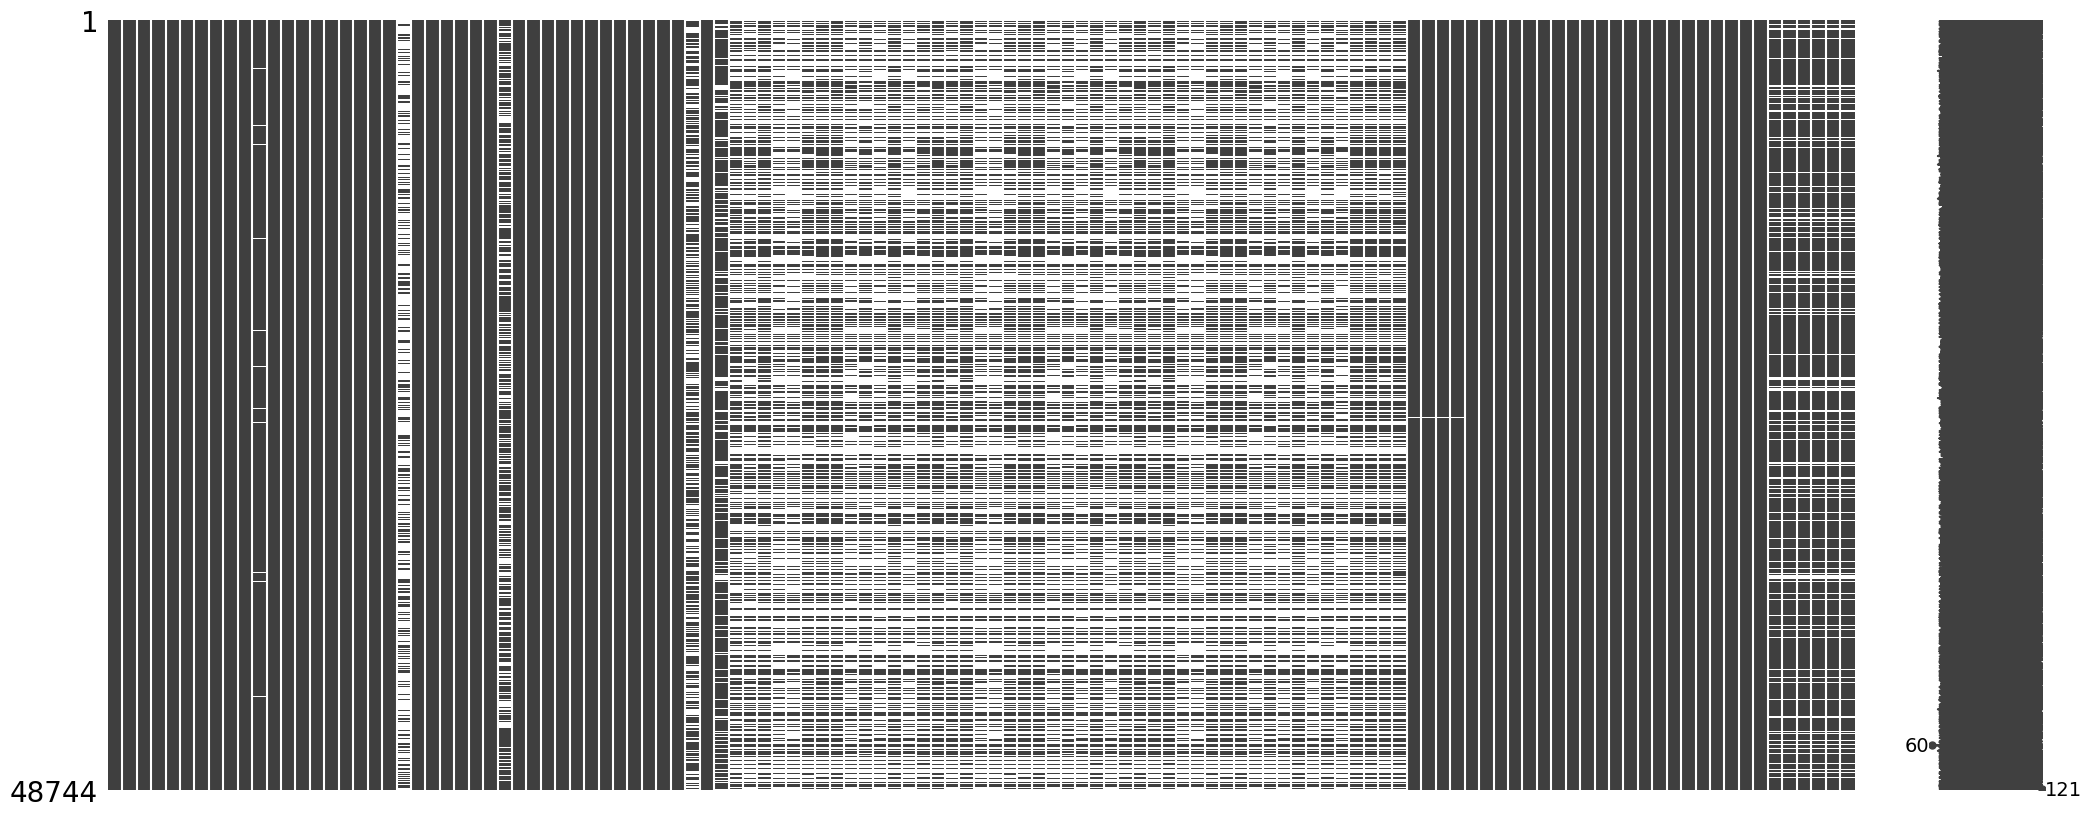

In [ ]:
msno.matrix(data_test)

## Application Train (data_train)

In [ ]:
data_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data_train.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
307510,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [ ]:
nb_lignes, nb_colonnes = data_train.shape
type_colonnes = data_train.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307511
Nombre de colonnes : 122
Type des colonnes : 
float64    65
int64      41
object     16
Name: count, dtype: int64


In [ ]:
data_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


DAYS_EMPLOYED présente une anomalie 365243 / 365 = 1000 ans.
___
- **SK_ID_CURR** : ID du prêt dans notre échantillon
- **TARGET** : Variable cible (1 - client ayant des difficultés de paiement : il/elle a eu un retard de paiement de plus de X jours sur au moins l'une des Y premières échéances du prêt dans notre échantillon, 0 - tous les autres cas)
- **NAME_CONTRACT_TYPE** : Identification si le prêt est au comptant ou renouvelable
- **CODE_GENDER** : Sexe du client
- **FLAG_OWN_CAR** : Indicateur si le client possède une voiture
- **FLAG_OWN_REALTY** : Indicateur si le client est propriétaire d'une maison ou d'un appartement
- **CNT_CHILDREN** : Nombre d'enfants du client
- **AMT_INCOME_TOTAL** : Revenu du client
- **AMT_CREDIT** : Montant du crédit du prêt
- **AMT_ANNUITY** : L'annuité du prêt
- **AMT_GOODS_PRICE** : Pour les prêts à la consommation, il s'agit du prix des biens pour lesquels le prêt est accordé.
- **NAME_TYPE_SUITE** : Qui accompagnait le client lorsqu'il a demandé le prêt ?
- **NAME_INCOME_TYPE** : Type de revenu du client (homme d'affaires, travailleur, congé de maternité,...)
- **NAME_EDUCATION_TYPE** : Niveau d'études le plus élevé atteint par le client
- **NAME_FAMILY_STATUS** : Situation familiale du client
- **NAME_HOUSING_TYPE** : Quelle est la situation du client en matière de logement (location, vie chez les parents, ...) ?
- **REGION_POPULATION_RELATIVE** : Population normalisée de la région où vit le client (un chiffre plus élevé signifie que le client vit dans une région plus peuplée)
- **DAYS_BIRTH** : Âge du client en jours au moment de la demande
- **DAYS_EMPLOYED** : Combien de jours avant la demande la personne a-t-elle commencé à travailler ?
- **DAYS_REGISTRATION** : Combien de jours avant la demande le client a-t-il changé d'inscription ?
- **DAYS_ID_PUBLISH** : Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt ?
- **OWN_CAR_AGE** : Âge de la voiture du client
- **FLAG_MOBIL** : Le client a-t-il fourni un téléphone portable (1=OUI, 0=NON) ?
- **FLAG_EMP_PHONE** : Le client a-t-il fourni un téléphone professionnel (1=OUI, 0=NON) ?
- **FLAG_WORK_PHONE** : Le client a-t-il fourni un téléphone à domicile (1=OUI, 0=NON) ?
- **FLAG_CONT_MOBILE** : Le téléphone portable était-il joignable (1=OUI, 0=NON)
- **FLAG_PHONE** : Le client a-t-il fourni un téléphone à domicile (1=OUI, 0=NON) ?
- **FLAG_EMAIL** : Le client a-t-il fourni une adresse électronique (1=OUI, 0=NON) ?
- **OCCUPATION_TYPE** : Quelle est la profession du client ?
- **CNT_FAM_MEMBERS** : Combien de membres le client a-t-il dans sa famille ?
- **REGION_RATING_CLIENT** : Notre évaluation de la région où vit le client (1,2,3)
- **REGION_RATING_CLIENT_W_CITY** : Notre évaluation de la région où vit le client en tenant compte de la ville (1,2,3)
- **WEEKDAY_APPR_PROCESS_START** : Quel jour de la semaine le client a-t-il demandé le prêt ?
- **HOUR_APPR_PROCESS_START** : A quelle heure environ le client a-t-il demandé le prêt ?
- **REG_REGION_NOT_LIVE_REGION** : Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différente, 0=même, au niveau de la région)
- **REG_REGION_NOT_WORK_REGION** : Indicateur si l'adresse permanente du client ne correspond pas à l'adresse du lieu de travail (1=différent, 0=même, au niveau régional)
- **LIVE_REGION_NOT_WORK_REGION** : Indicateur si l'adresse de contact du client ne correspond pas à l'adresse du lieu de travail (1=différent, 0=même, au niveau de la région)
- **REG_CITY_NOT_LIVE_CITY** : Indicateur si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent, 0=même, au niveau de la ville)
- **REG_CITY_NOT_WORK_CITY** : Indicateur si l'adresse permanente du client ne correspond pas à l'adresse du lieu de travail (1=différent, 0=même, au niveau de la ville)
- **LIVE_CITY_NOT_WORK_CITY** : Indicateur si l'adresse de contact du client ne correspond pas à l'adresse de travail (1=différent, 0=même, au niveau de la ville)
- **ORGANIZATION_TYPE** : Type d'organisation où le client travaille
- **EXT_SOURCE_1** : Score normalisé à partir d'une source de données externe
- **EXT_SOURCE_2** : Score normalisé à partir d'une source de données externe
- **EXT_SOURCE_3** : Score normalisé à partir d'une source de données externe
- **APARTMENTS_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **BASEMENTAREA_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **YEARS_BEGINEXPLUATATION_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **YEARS_BUILD_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **COMMONAREA_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **ELEVATORS_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **ENTRANCES_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **FLOORSMAX_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **FLOORSMIN_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LANDAREA_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LIVINGAPARTMENTS_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LIVINGAREA_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **NONLIVINGAPARTMENTS_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **NONLIVINGAREA_AVG** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **APARTMENTS_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **BASEMENTAREA_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **YEARS_BEGINEXPLUATATION_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **YEARS_BUILD_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **COMMONAREA_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **ELEVATORS_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **ENTRANCES_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **FLOORSMAX_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **FLOORSMIN_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LANDAREA_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LIVINGAPARTMENTS_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LIVINGAREA_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **NONLIVINGAPARTMENTS_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **NONLIVINGAREA_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **APARTMENTS_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **BASEMENTAREA_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **YEARS_BEGINEXPLUATATION_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **YEARS_BUILD_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **COMMONAREA_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **ELEVATORS_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **ENTRANCES_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **FLOORSMAX_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **FLOORSMIN_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LANDAREA_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LIVINGAPARTMENTS_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **LIVINGAREA_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **NONLIVINGAPARTMENTS_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **NONLIVINGAREA_MEDI** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **FONDKAPREMONT_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **HOUSETYPE_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **TOTALAREA_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **WALLSMATERIAL_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **EMERGENCYSTATE_MODE** : Informations normalisées sur l'immeuble où vit le client, quelle est la taille moyenne (suffixe _AVG), modus (suffixe _MODE), médiane (suffixe _MEDI) de l'appartement, la surface commune, la surface habitable, l'âge de l'immeuble, le nombre d'ascenseurs, le nombre d'entrées, l'état de l'immeuble, le nombre d'étages, etc.
- **OBS_30_CNT_SOCIAL_CIRCLE** : Combien d'observations de l'environnement social du client avec un défaut de paiement observable de 30 jours ?
- **DEF_30_CNT_SOCIAL_CIRCLE** : Combien d'observations de l'environnement social du client ont fait l'objet d'un défaut de paiement à 30 DPD (jours de retard) ?
- **OBS_60_CNT_SOCIAL_CIRCLE** : Combien d'observations de l'environnement social du client avec un défaut de paiement de 60 jours ?
- **DEF_60_CNT_SOCIAL_CIRCLE** : Combien d'observations de l'environnement social du client ont fait l'objet d'une défaillance à 60 jours de retard ?
- **DAYS_LAST_PHONE_CHANGE** : Combien de jours avant la demande le client a-t-il changé de téléphone ?
- **FLAG_DOCUMENT_2** : Le client a-t-il fourni le document 2 ?
- **FLAG_DOCUMENT_3** : Le client a-t-il fourni le document 3 ?
- **FLAG_DOCUMENT_4** : Le client a-t-il fourni un document 4 ?
- **FLAG_DOCUMENT_5** : Le client a-t-il fourni un document 5 ?
- **FLAG_DOCUMENT_6** : Le client a-t-il fourni un document 6 ?
- **FLAG_DOCUMENT_7** : Le client a fourni le document 7
- **FLAG_DOCUMENT_8** : Le client a fourni le document 8
- **FLAG_DOCUMENT_9** : Le client a fourni un document 9
- **FLAG_DOCUMENT_10** : Le client a fourni un document 10
- **FLAG_DOCUMENT_11** : Le client a fourni le document 11
- **FLAG_DOCUMENT_12** : Le client a fourni un document 12
- **FLAG_DOCUMENT_13** : Le client a fourni le document 13
- **FLAG_DOCUMENT_14** : Le client a fourni le document 14
- **FLAG_DOCUMENT_15** : Le client a fourni le document 15
- **FLAG_DOCUMENT_16** : Le client a fourni le document 16
- **FLAG_DOCUMENT_17** : Le client a fourni le document 17
- **FLAG_DOCUMENT_18** : Le client a fourni un document 18
- **FLAG_DOCUMENT_19** : Le client a fourni le document 19
- **FLAG_DOCUMENT_20** : Le client a fourni le document 20
- **FLAG_DOCUMENT_21** : Le client a-t-il fourni le document 21
- **AMT_REQ_CREDIT_BUREAU_HOUR** : Nombre de demandes de renseignements sur le client auprès de l'agence d'évaluation du crédit une heure avant la demande
- **AMT_REQ_CREDIT_BUREAU_DAY** : Nombre de demandes de renseignements sur le client adressées à l'agence d'évaluation du crédit un jour avant la demande (à l'exclusion d'une heure avant la demande)
- **AMT_REQ_CREDIT_BUREAU_WEEK** : Nombre de demandes de renseignements sur le client adressées à l'agence d'évaluation du crédit une semaine avant la demande (à l'exclusion d'un jour avant la demande)
- **AMT_REQ_CREDIT_BUREAU_MON** : Nombre de demandes de renseignements sur le client adressées à l'agence d'évaluation du crédit un mois avant la demande (à l'exclusion d'une semaine avant la demande)
- **AMT_REQ_CREDIT_BUREAU_QRT** : Nombre de demandes de renseignements sur le client auprès d'un bureau de crédit 3 mois avant la demande (sauf un mois avant la demande)
- **AMT_REQ_CREDIT_BUREAU_YEAR** : Nombre de demandes de renseignements sur le client adressées au bureau de crédit un jour par an (à l'exclusion des trois derniers mois précédant la demande)
___

<Axes: >

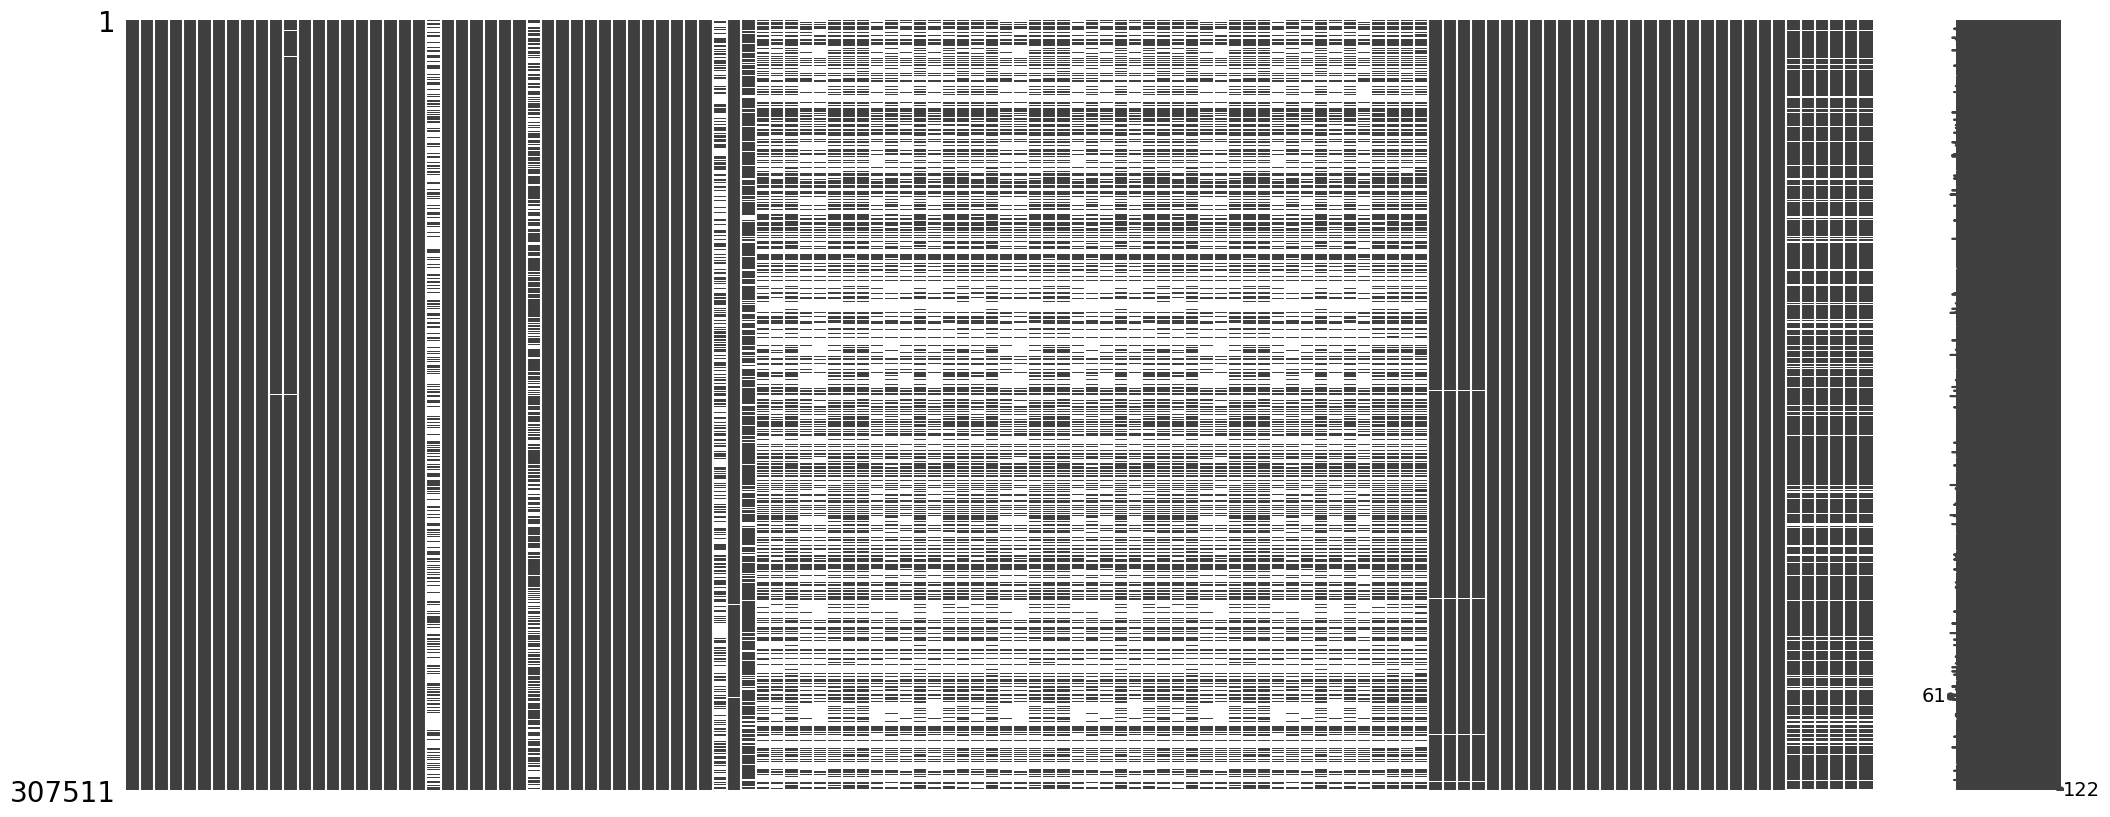

In [ ]:
msno.matrix(data_train)

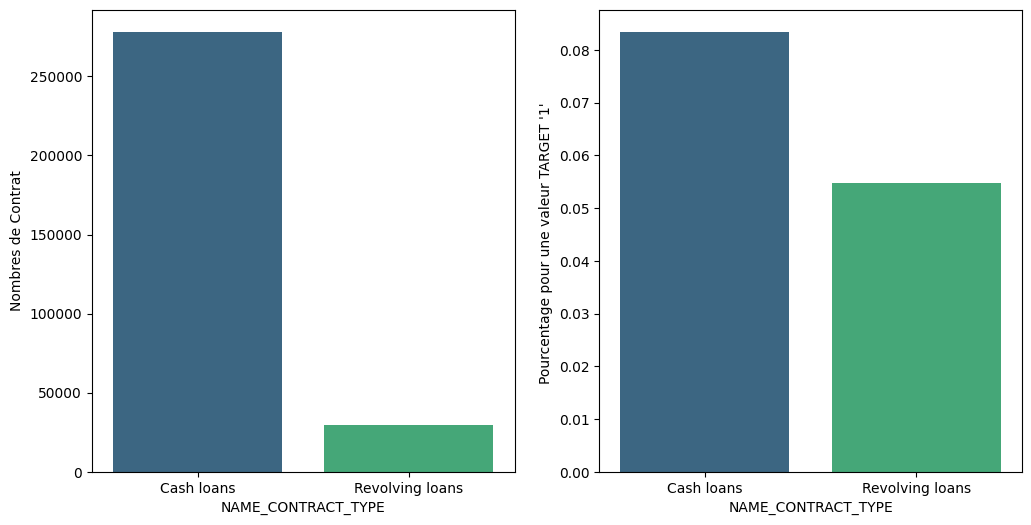

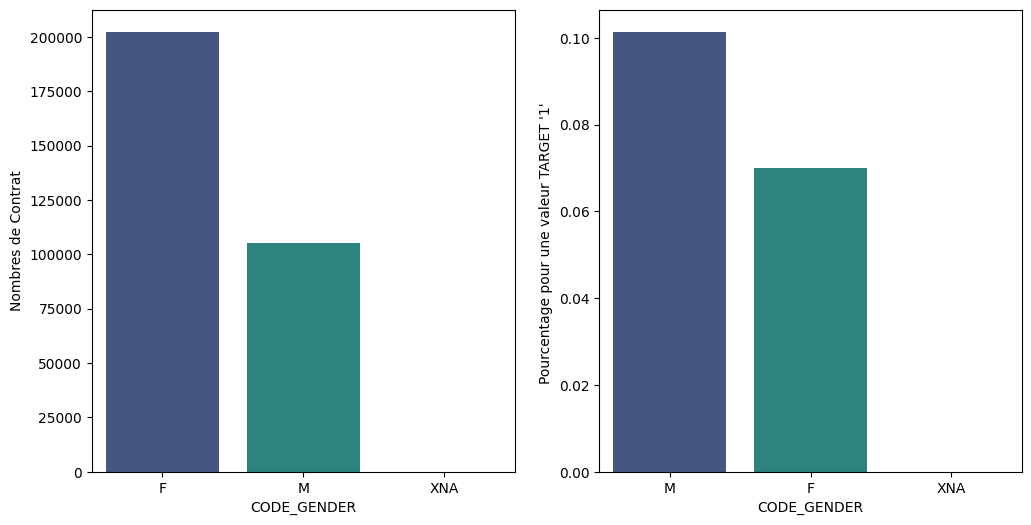

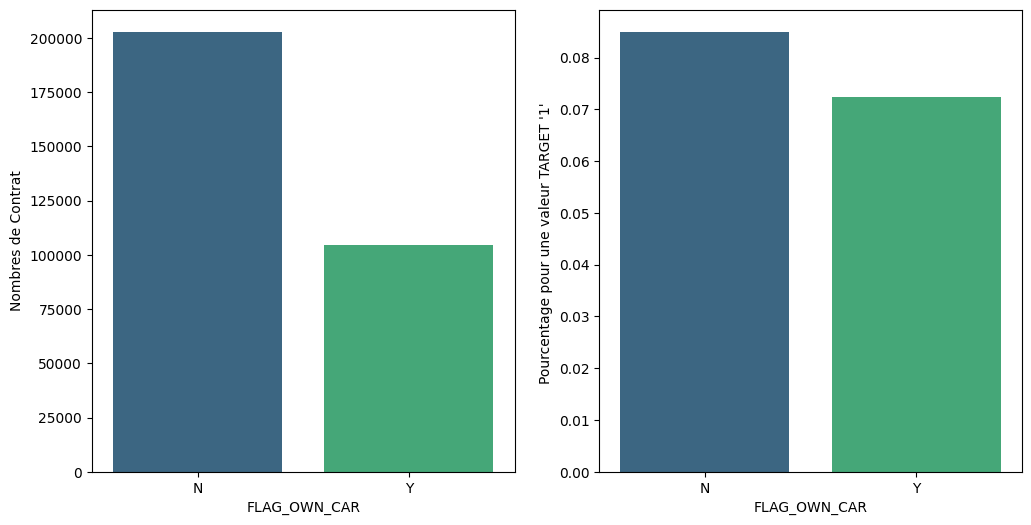

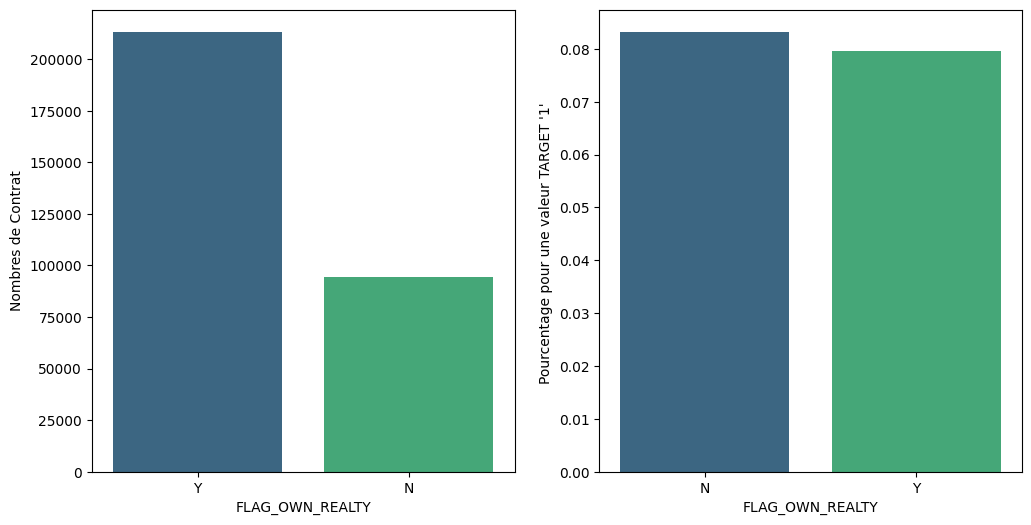

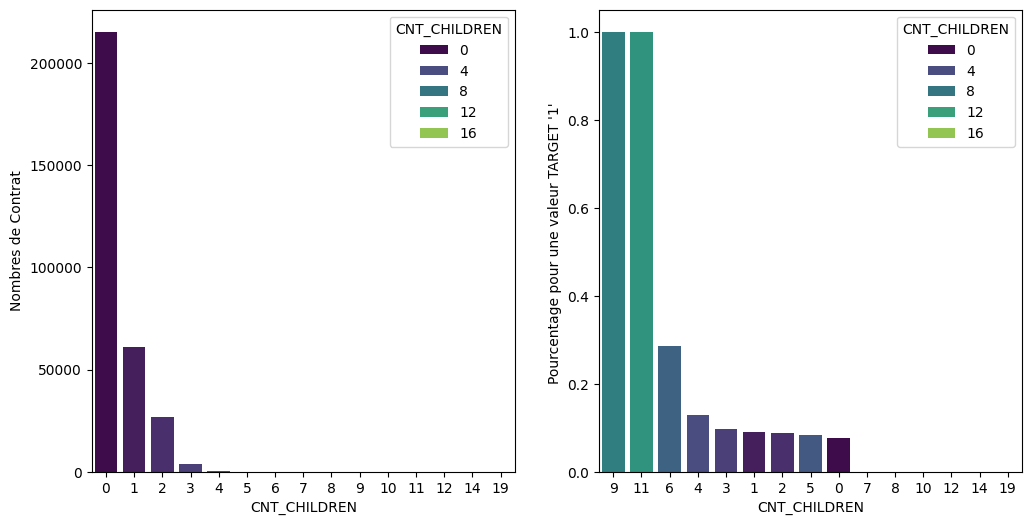

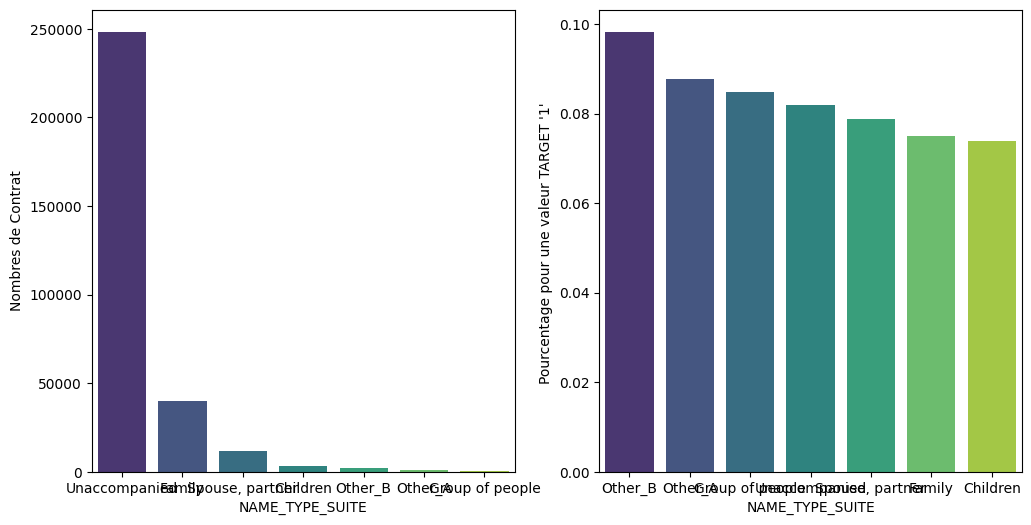

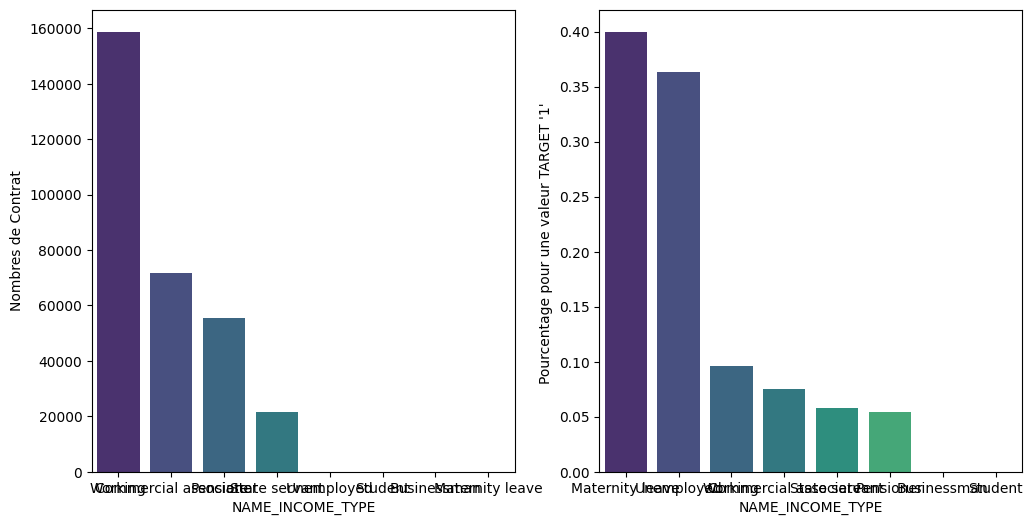

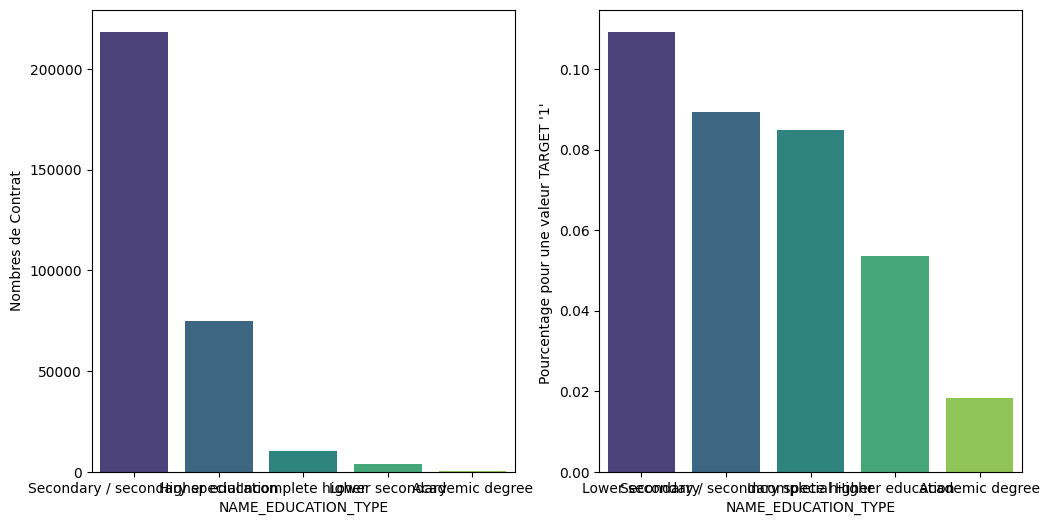

In [ ]:
graph_stats("NAME_CONTRACT_TYPE");
graph_stats("CODE_GENDER");
graph_stats("FLAG_OWN_CAR");
graph_stats("FLAG_OWN_REALTY");
graph_stats("CNT_CHILDREN");
graph_stats("NAME_TYPE_SUITE");
graph_stats("NAME_INCOME_TYPE");
graph_stats("NAME_EDUCATION_TYPE");

In [ ]:
data_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

### Correction des d'anomalies

Text(0.5, 0, "Ancienneté d'emploi")

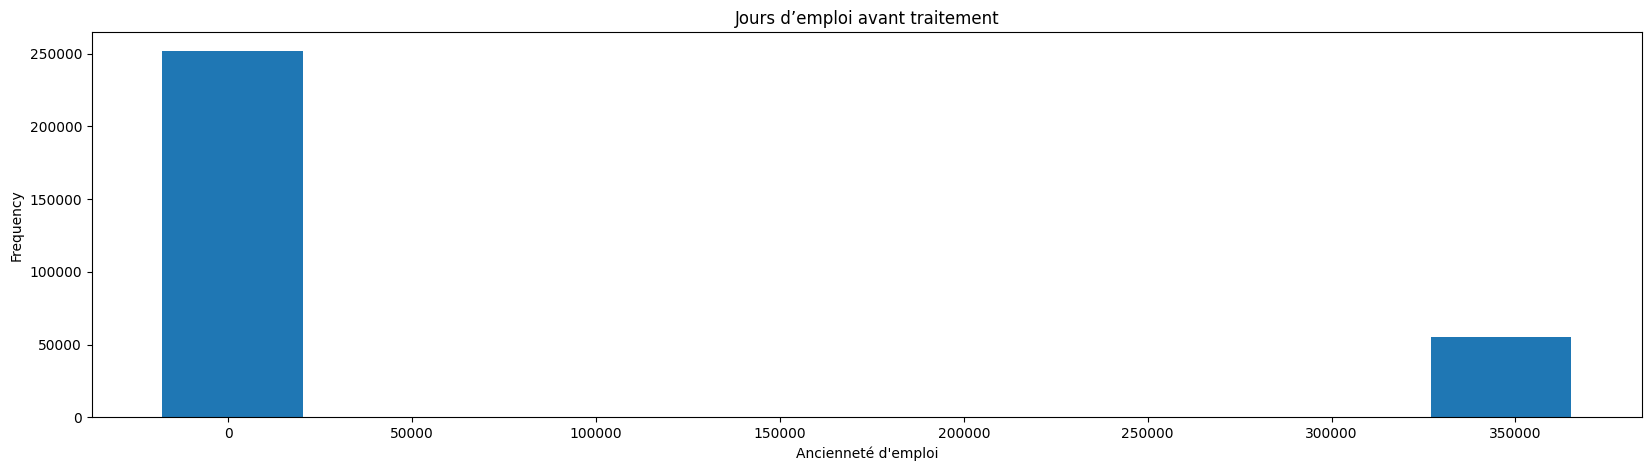

In [ ]:
# Visualisation de l'anomalie détécté dans le describe
data_train['DAYS_EMPLOYED'].plot.hist(title ="Jours d’emploi avant traitement", figsize=(20,5))
plt.xlabel("Ancienneté d'emploi")

In [ ]:
# Comptage des occurences
count_365243 = (data_train["DAYS_EMPLOYED"] == 365243).sum()
print(f"La valeur 365243 apparaît {count_365243} fois dans la colonne DAYS_EMPLOYED.")

La valeur 365243 apparaît 55374 fois dans la colonne DAYS_EMPLOYED.


In [ ]:
# 2. Remplacement des valeurs 365243 par NaN
data_train["DAYS_EMPLOYED"] = data_train["DAYS_EMPLOYED"].replace(365243, np.nan)

Text(0.5, 0, "Ancienneté d'emploi")

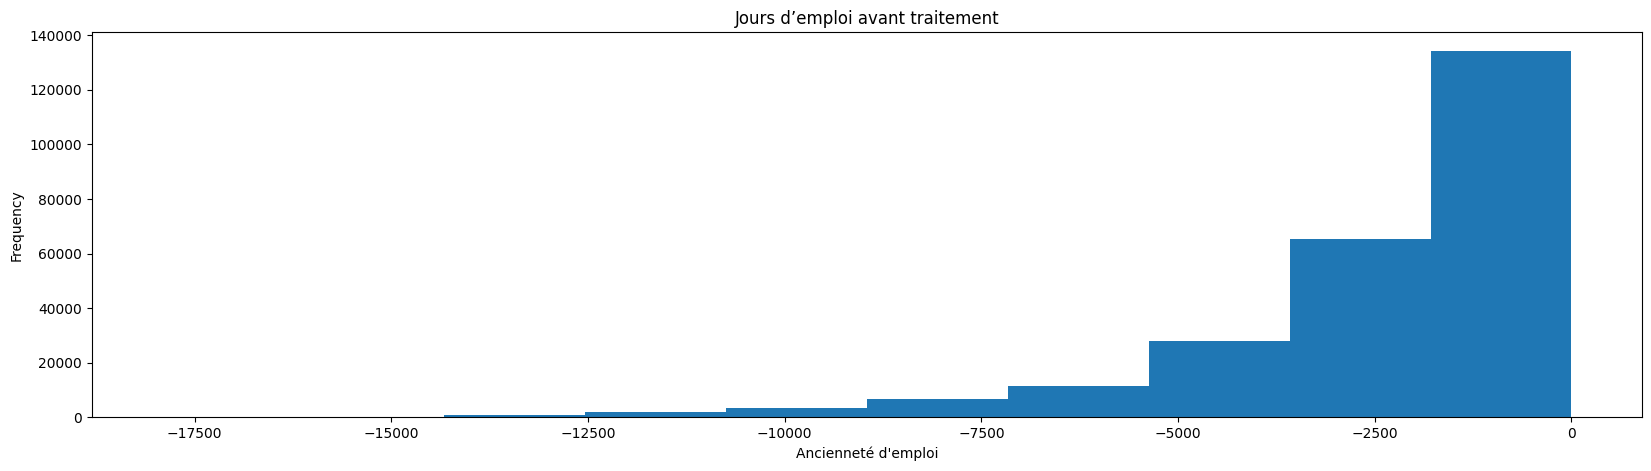

In [ ]:
# Vérification de l'anomalie détécté dans le describe
data_train["DAYS_EMPLOYED"].plot.hist(title ="Jours d’emploi avant traitement", figsize=(20,5))
plt.xlabel("Ancienneté d'emploi")

In [ ]:
# Apercu des occurences de "XNA"
data_train["CODE_GENDER"].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

In [ ]:
# Suppression des lignes où CODE_GENDER n'est pas égal à "XNA"
data_train = data_train[data_train["CODE_GENDER"] != "XNA"]

# Vérifier si les valeurs XNA ont été supprimées
print(data_train["CODE_GENDER"].value_counts())

CODE_GENDER
F    202448
M    105059
Name: count, dtype: int64


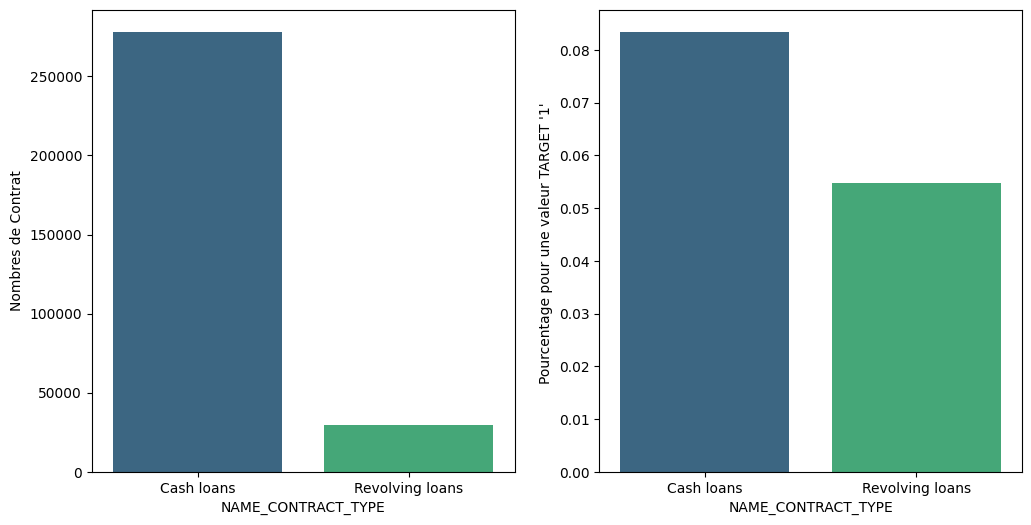

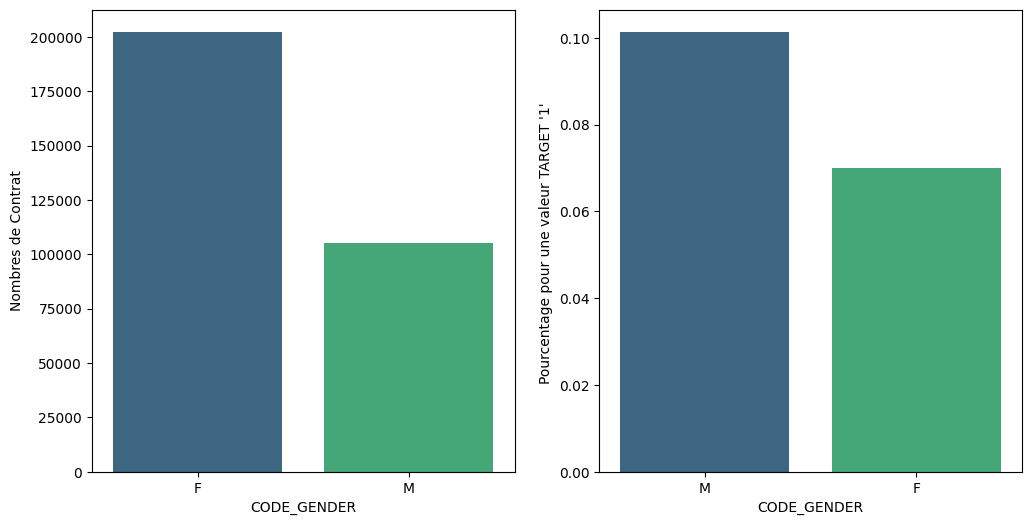

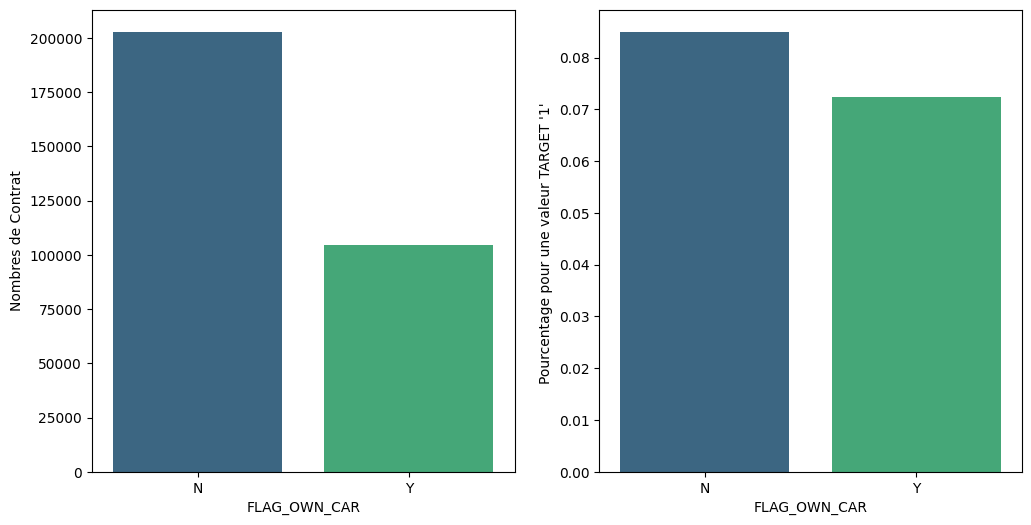

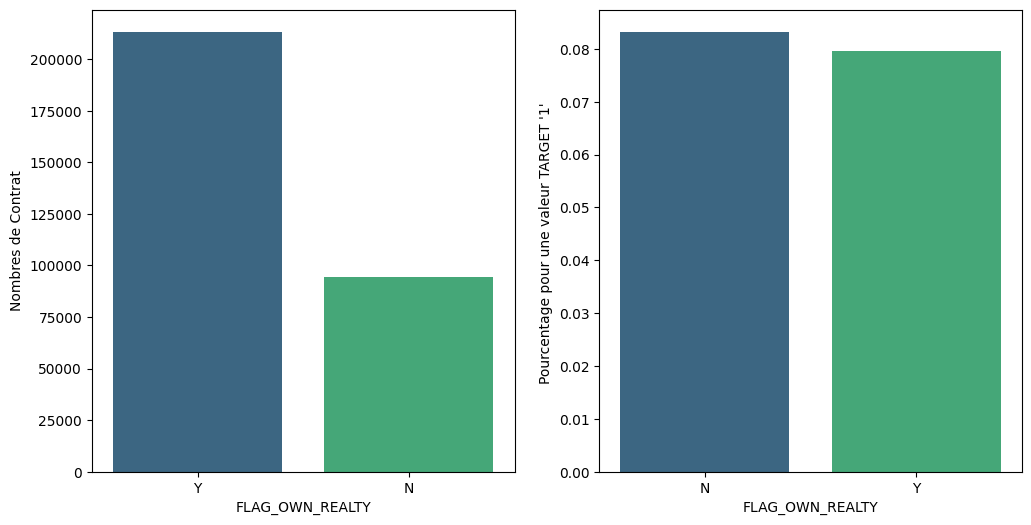

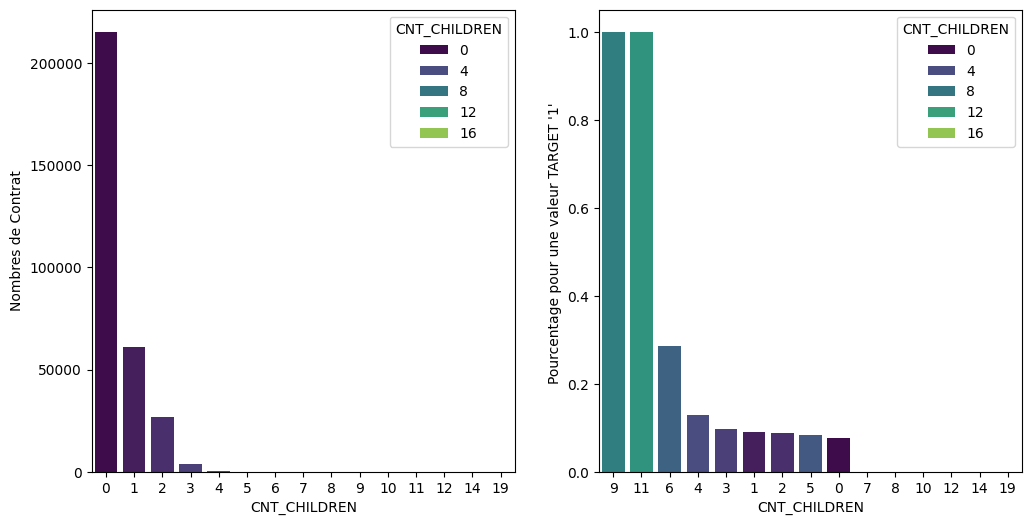

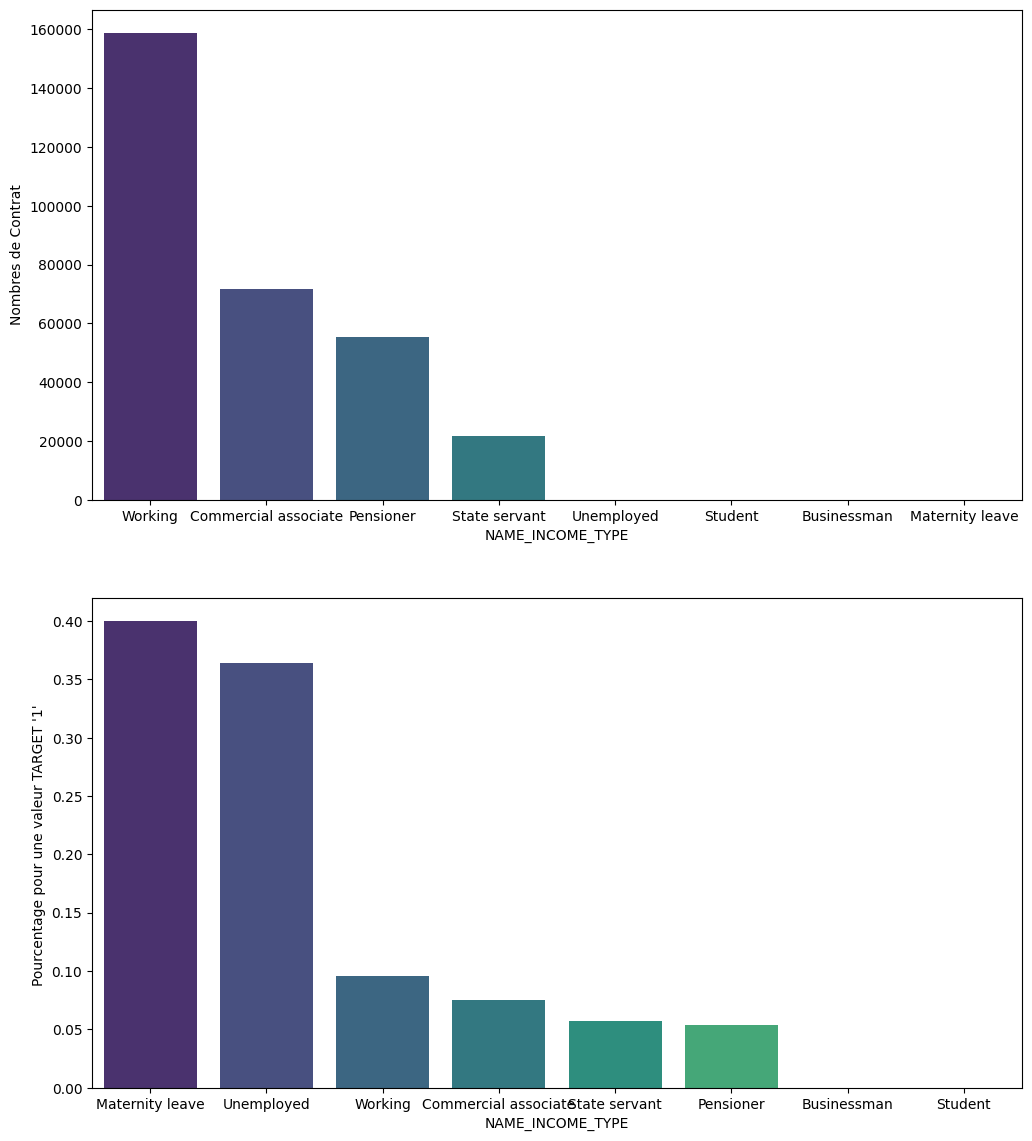

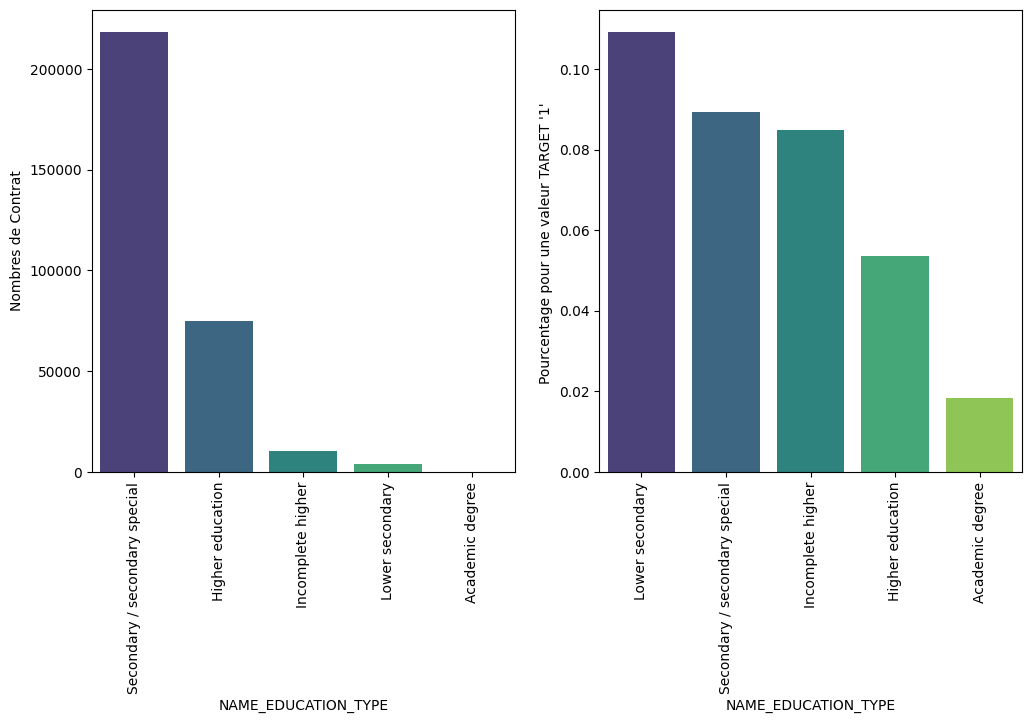

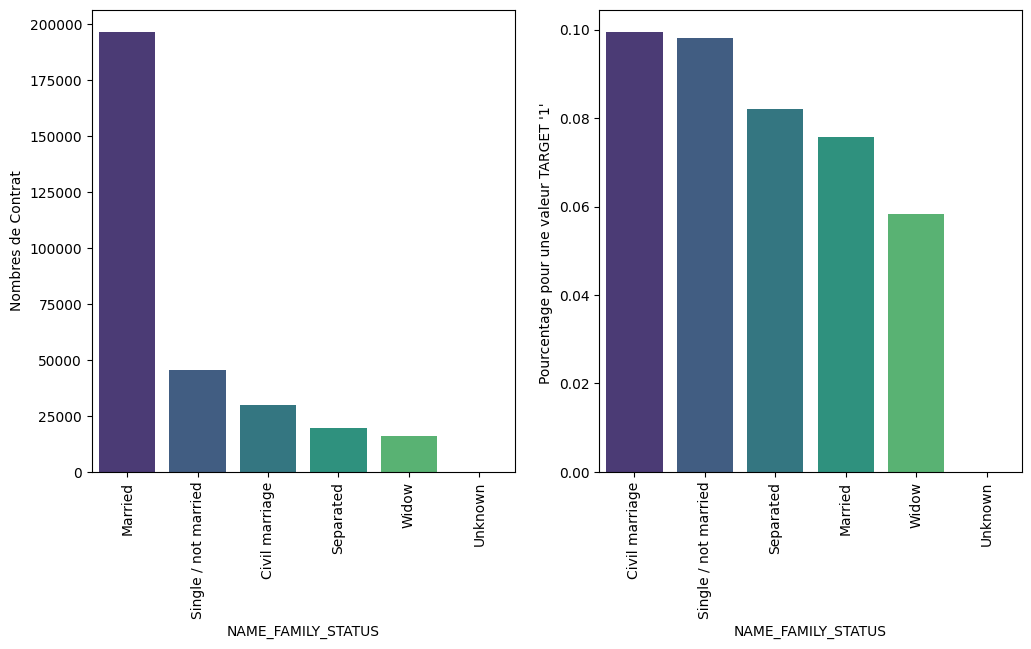

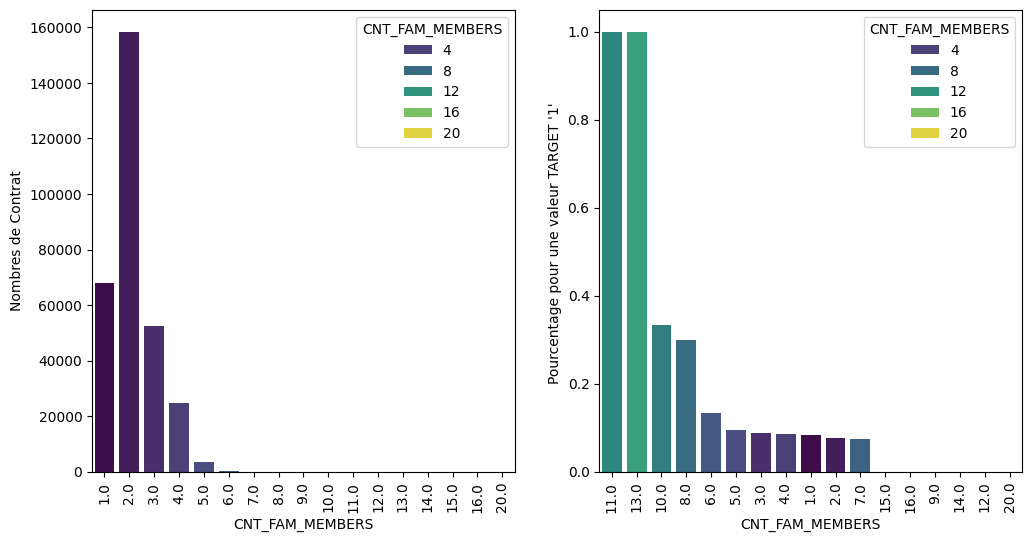

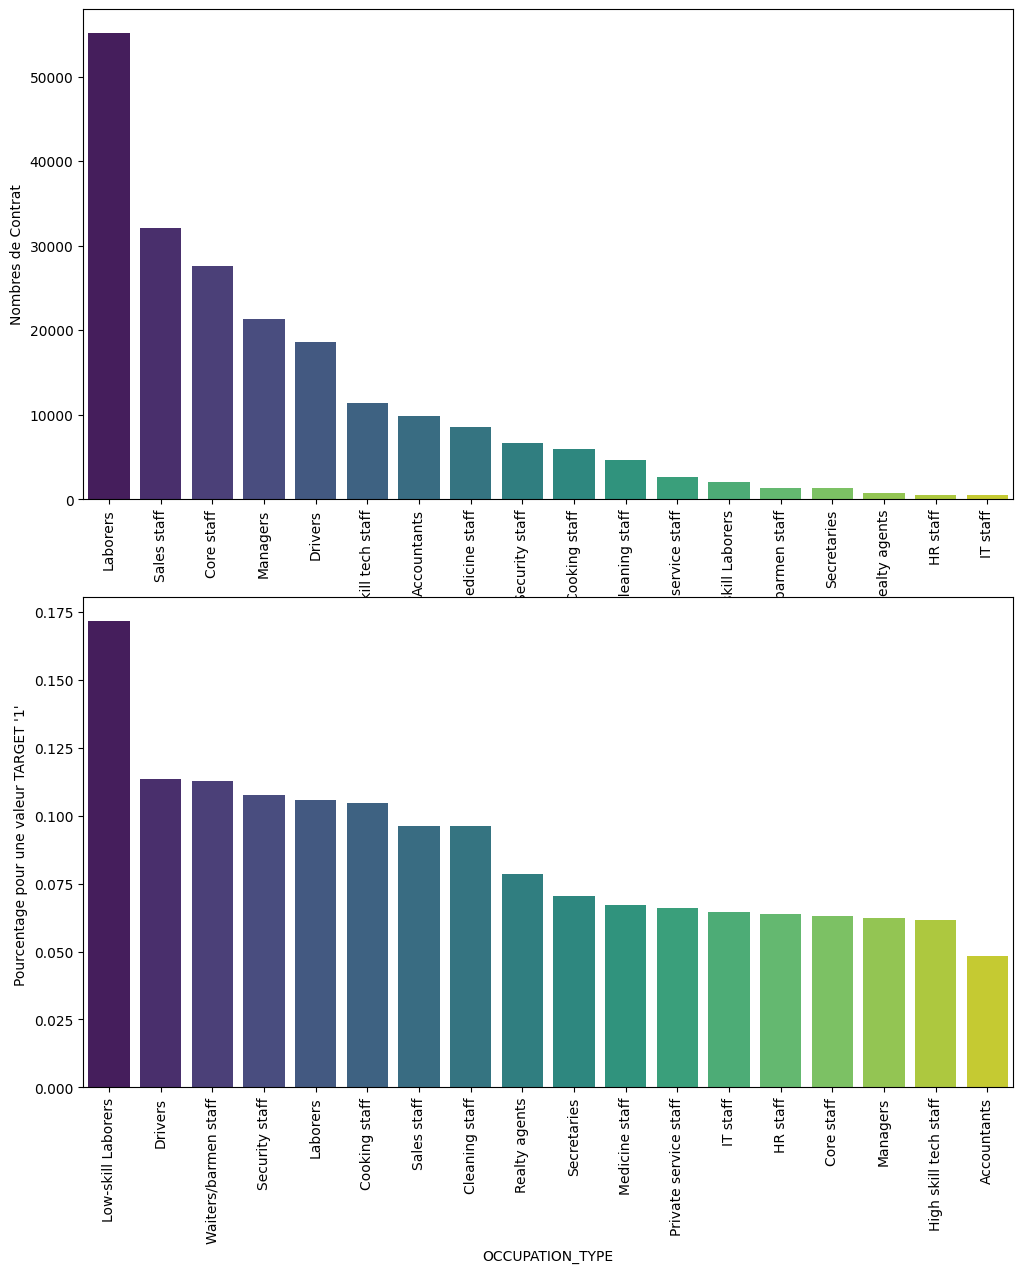

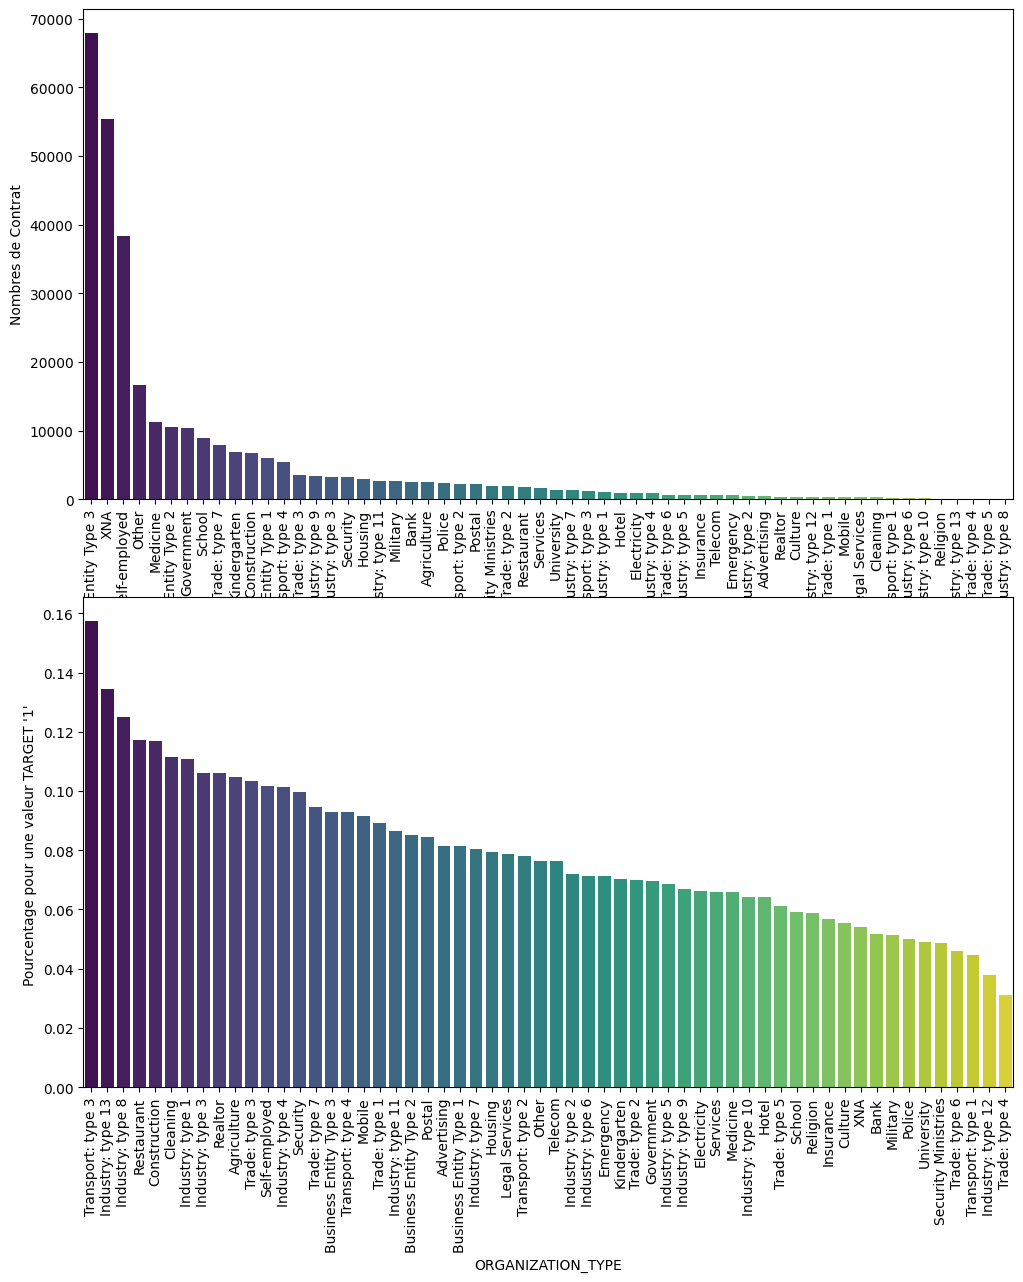

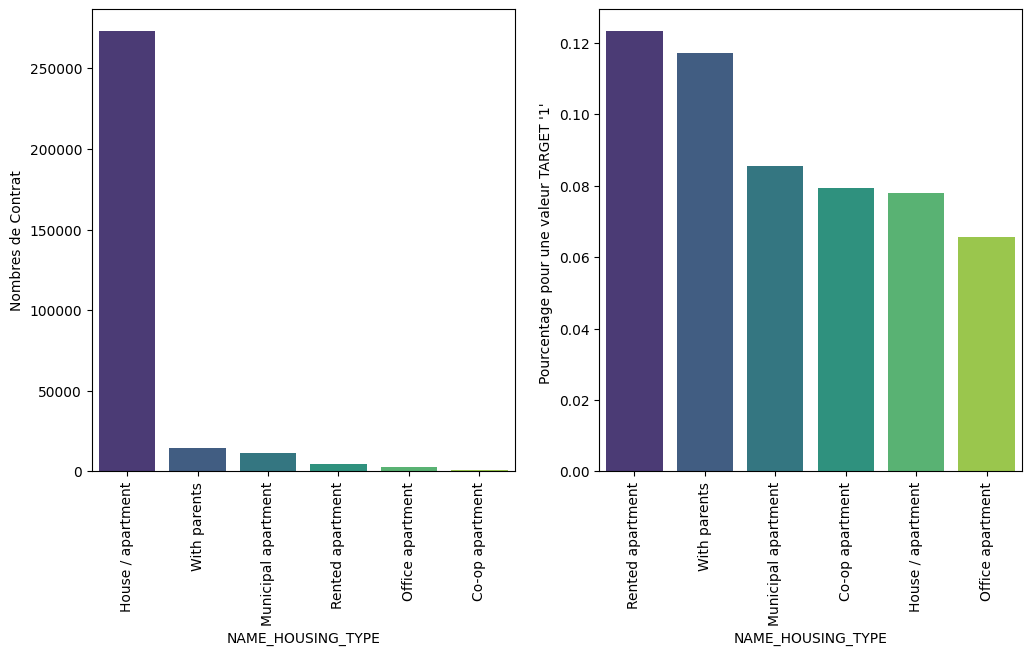

In [ ]:
graph_stats("NAME_CONTRACT_TYPE")
graph_stats("CODE_GENDER")
graph_stats("FLAG_OWN_CAR")
graph_stats("FLAG_OWN_REALTY")
graph_stats("CNT_CHILDREN")
graph_stats("NAME_INCOME_TYPE", False, False)
graph_stats("NAME_EDUCATION_TYPE", True)
graph_stats("NAME_FAMILY_STATUS", True, True)
graph_stats("CNT_FAM_MEMBERS", True)
graph_stats("OCCUPATION_TYPE", True, False)
graph_stats("ORGANIZATION_TYPE", True, False)
graph_stats("NAME_HOUSING_TYPE", True)


## Bureau Balance (data_bb)

In [ ]:
data_bb.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [ ]:
data_bb.tail()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X
27299924,5041336,-51,X


In [ ]:
data_bb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [ ]:
nb_lignes, nb_colonnes = data_bb.shape
type_colonnes = data_bb.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 27299925
Nombre de colonnes : 3
Type des colonnes : 
int64     2
object    1
Name: count, dtype: int64


In [ ]:
data_bb.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


 - **SK_BUREAU_ID** : ID recodé du crédit du bureau de crédit (codage unique pour chaque demande) - à utiliser pour joindre la table CREDIT_BUREAU
 - **MONTHS_BALANCE** : Mois du solde par rapport à la date de la demande (-1 signifie la date de solde la plus récente)
 - **STATUS** : Statut du prêt du bureau de crédit au cours du mois (actif, fermé, DPD0-30,... [C signifie fermé, X signifie statut inconnu, 0 signifie pas de DPD, 1 signifie DPD maximale au cours du mois entre 1-30, 2 signifie DPD 31-60,... 5 signifie DPD 120+ ou vendu ou passé par pertes et profits ] )

<Axes: >

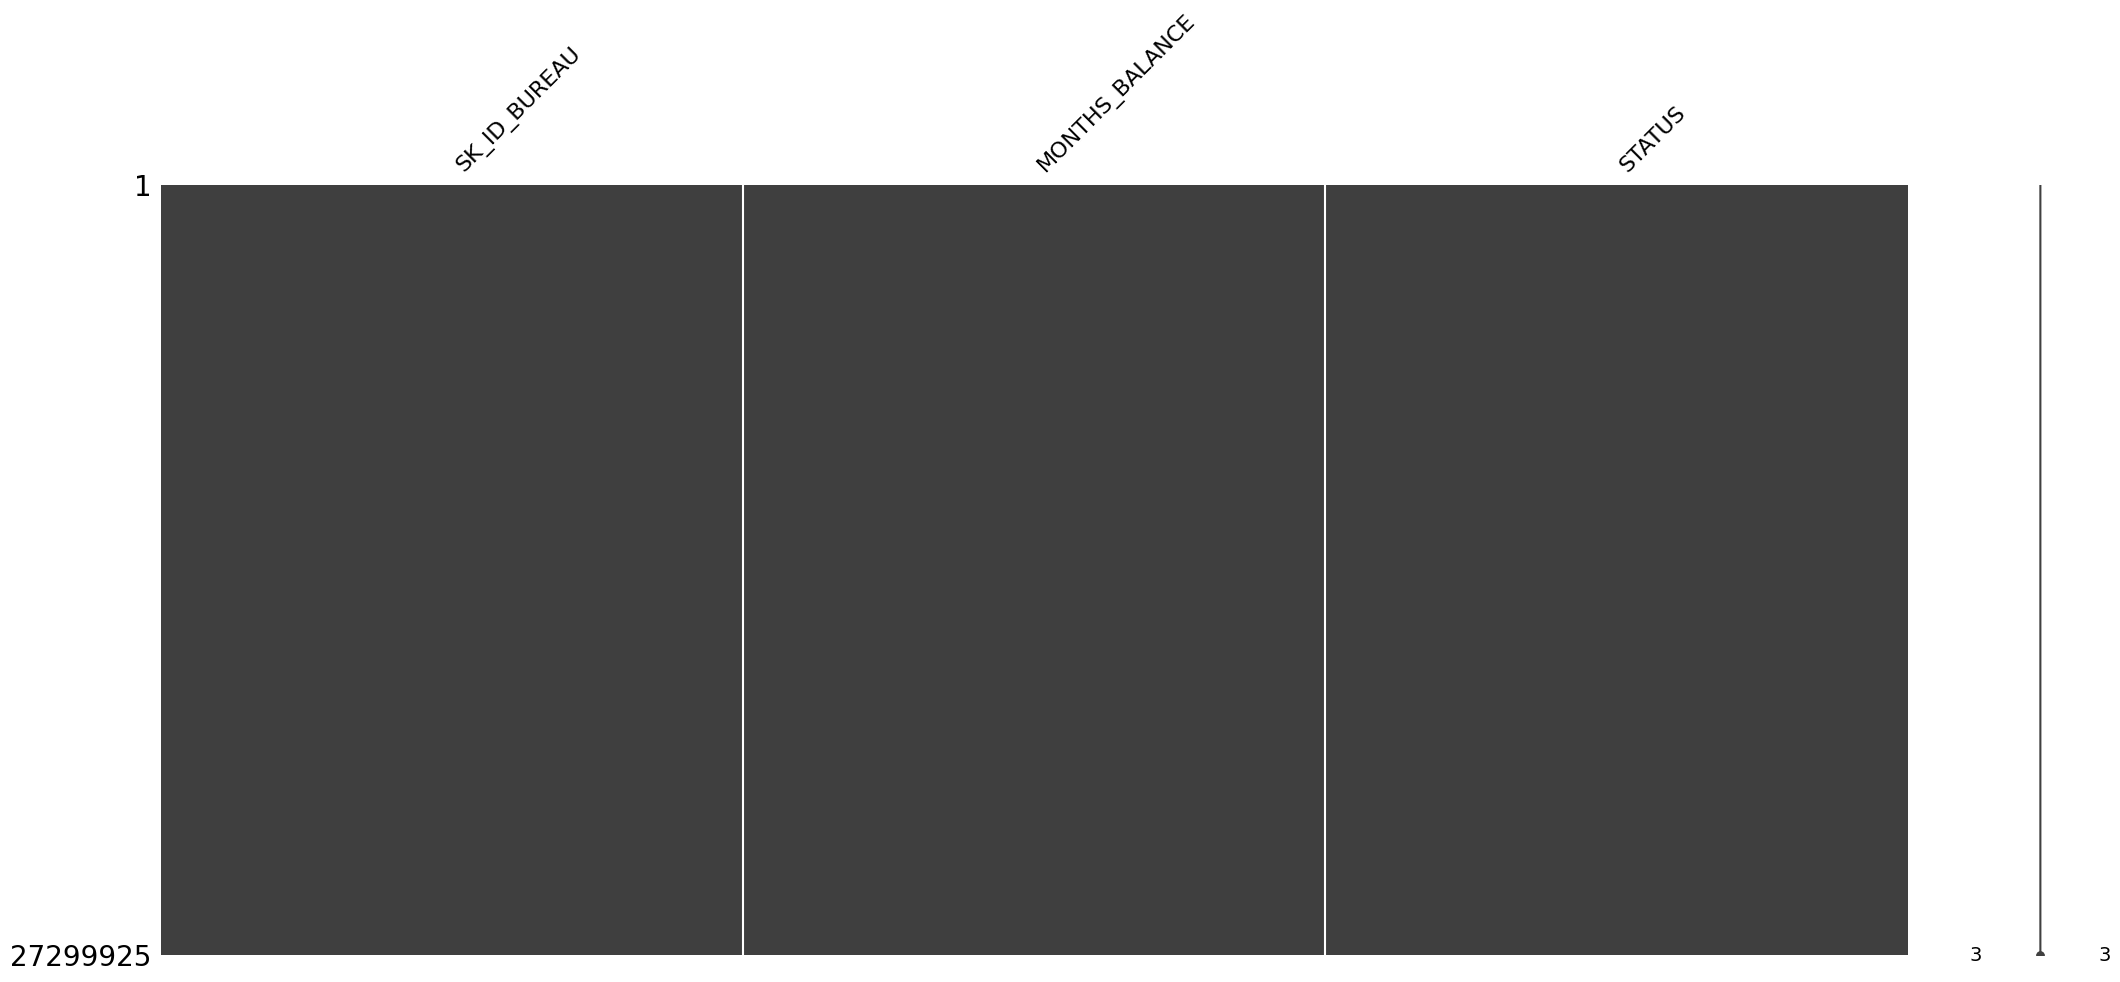

In [ ]:
msno.matrix(data_bb)

## Bureau (data_bureau)

In [ ]:
data_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:
data_bureau.tail()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN
1716427,246829,5057778,Closed,currency 1,-463,0,NaN,-387.0,NaN,0,22500.00,0.0,NaN,0.0,Microloan,-387,NaN


In [ ]:
data_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [ ]:
nb_lignes, nb_colonnes = data_bureau.shape
type_colonnes = data_bureau.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 1716428
Nombre de colonnes : 17
Type des colonnes : 
float64    8
int64      6
object     3
Name: count, dtype: int64


In [ ]:
data_bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


 - **SK_ID_CURR** : ID du prêt dans notre échantillon - un prêt dans notre échantillon peut avoir 0,1,2 ou plus de crédits antérieurs liés dans le bureau de crédit.
 - **SK_BUREAU_ID** : ID recodé du crédit antérieur du bureau de crédit lié à notre prêt (codage unique pour chaque demande de prêt)
 - **CREDIT_ACTIVE** : Statut des crédits rapportés par le Credit Bureau (CB)
 - **CREDIT_CURRENCY** : Devise recodée du crédit du bureau de crédit
 - **DAYS_CREDIT** : Combien de jours avant la demande actuelle le client a-t-il fait une demande de crédit auprès d'un bureau de crédit ?
 - **CREDIT_DAY_OVERDUE** : Nombre de jours de retard sur le crédit CB au moment de la demande de prêt connexe dans notre échantillon
 - **DAYS_CREDIT_ENDDATE** : Durée restante du crédit CB (en jours) au moment de la demande de crédit domestique
 - **DAYS_ENDDATE_FACT** : Nombre de jours écoulés depuis la fin du crédit CB au moment de la demande de crédit à l'habitat (uniquement pour les crédits clôturés)
 - **AMT_CREDIT_MAX_OVERDUE** : Montant maximal de l'arriéré du crédit du bureau de crédit (à la date de la demande de prêt dans notre échantillon)
 - **CNT_CREDIT_PROLONG** : Combien de fois le crédit du bureau de crédit a-t-il été prolongé ?
 - **AMT_CREDIT_SUM** : Montant actuel du crédit du bureau de crédit
 - **AMT_CREDIT_SUM_DEBT** : Dette actuelle sur le crédit de l'organisme de crédit
 - **AMT_CREDIT_SUM_LIMIT** : Limite de crédit actuelle de la carte de crédit déclarée au bureau de crédit
 - **AMT_CREDIT_SUM_OVERDUE** : Montant actuel de l'impayé sur le crédit du bureau de crédit
 - **CREDIT_TYPE** : Type de crédit accordé par l'organisme de crédit (voiture, argent liquide,...)
 - **DAYS_CREDIT_UPDATE** : Combien de jours avant la demande de prêt la dernière information sur le crédit du bureau de crédit a-t-elle été communiquée ?
 - **AMT_ANNUITY** : Annuité du crédit du bureau de crédit

<Axes: >

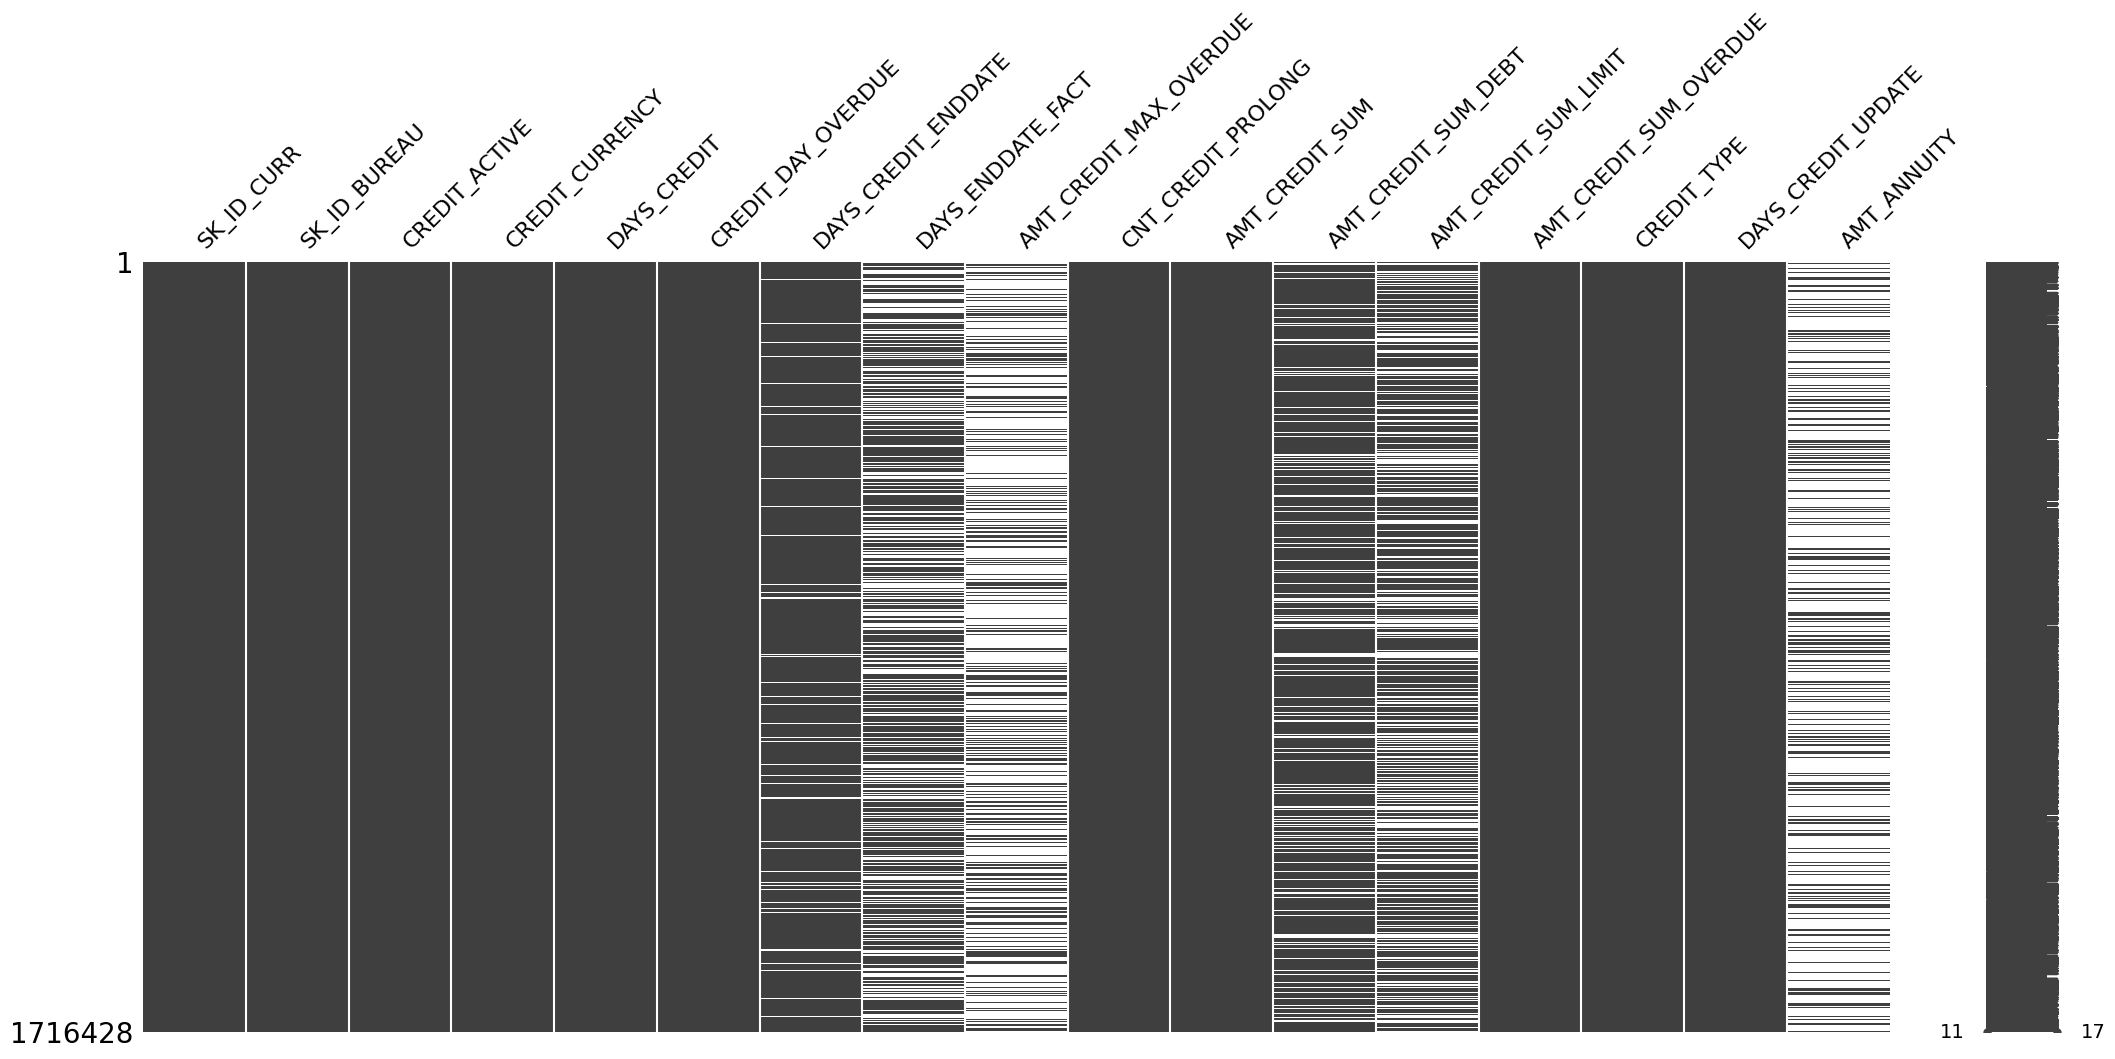

In [ ]:
msno.matrix(data_bureau)

## Crédit Card Balance (data_ccb)

In [ ]:
data_ccb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [ ]:
data_ccb.tail()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.0,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.0,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.0,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840311,2411345,236760,-10,0.000,157500,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.0,0,0.0,0.0,21.0,Completed,0,0


In [ ]:
data_ccb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [ ]:
nb_lignes, nb_colonnes = data_ccb.shape
type_colonnes = data_ccb.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 3840312
Nombre de colonnes : 23
Type des colonnes : 
float64    15
int64       7
object      1
Name: count, dtype: int64


In [ ]:
data_ccb.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


 - **SK_ID_PREV** : ID du crédit antérieur dans le crédit à l'habitat lié au prêt dans notre échantillon. (Un prêt de notre échantillon peut avoir 0, 1, 2 ou plus de prêts antérieurs en crédit immobilier)
 - **SK_ID_CURR** : ID du prêt dans notre échantillon
 - **MONTHS_BALANCE** : Mois du solde par rapport à la date de la demande (-1 signifie la date de solde la plus récente)
 - **AMT_BALANCE** : Solde au cours du mois du crédit précédent
 - **AMT_CREDIT_LIMIT_ACTUAL** : Limite de la carte de crédit pendant le mois du crédit précédent
 - **AMT_DRAWINGS_ATM_CURRENT** : Montant prélevé au distributeur automatique de billets au cours du mois du crédit précédent
 - **AMT_DRAWINGS_CURRENT** : Montant du tirage au cours du mois du crédit précédent
 - **AMT_DRAWINGS_OTHER_CURRENT** : Montant des autres prélèvements au cours du mois du crédit précédent
 - **AMT_DRAWINGS_POS_CURRENT** : Montant du prélèvement ou de l'achat de biens au cours du mois du crédit précédent
 - **AMT_INST_MIN_REGULARITY** : Versement minimal pour ce mois du crédit précédent
 - **AMT_PAYMENT_CURRENT** : Combien le client a-t-il payé au cours du mois sur le crédit précédent ?
 - **AMT_PAYMENT_TOTAL_CURRENT** : Combien le client a-t-il payé au total au cours du mois pour le crédit précédent ?
 - **AMT_RECEIVABLE_PRINCIPAL** : Montant à recevoir pour le principal sur le crédit précédent
 - **AMT_RECIVABLE** : Montant à recevoir pour le crédit précédent
 - **AMT_TOTAL_RECEIVABLE** : Montant total à recevoir sur le crédit précédent
 - **CNT_DRAWINGS_ATM_CURRENT** : Nombre de tirages au guichet automatique au cours de ce mois sur le crédit précédent
 - **CNT_DRAWINGS_CURRENT** : Nombre de tirages au cours de ce mois sur le crédit précédent
 - **CNT_DRAWINGS_OTHER_CURRENT** : Nombre d'autres tirages au cours de ce mois sur le crédit précédent
 - **CNT_DRAWINGS_POS_CURRENT** : Nombre de tirages de marchandises au cours de ce mois sur le crédit précédent
 - **CNT_INSTALMENT_MATURE_CUM** : Nombre d'échéances payées sur le crédit précédent
 - **NAME_CONTRACT_STATUS** : Statut du contrat (actif, signé,...) sur le crédit précédent

<Axes: >

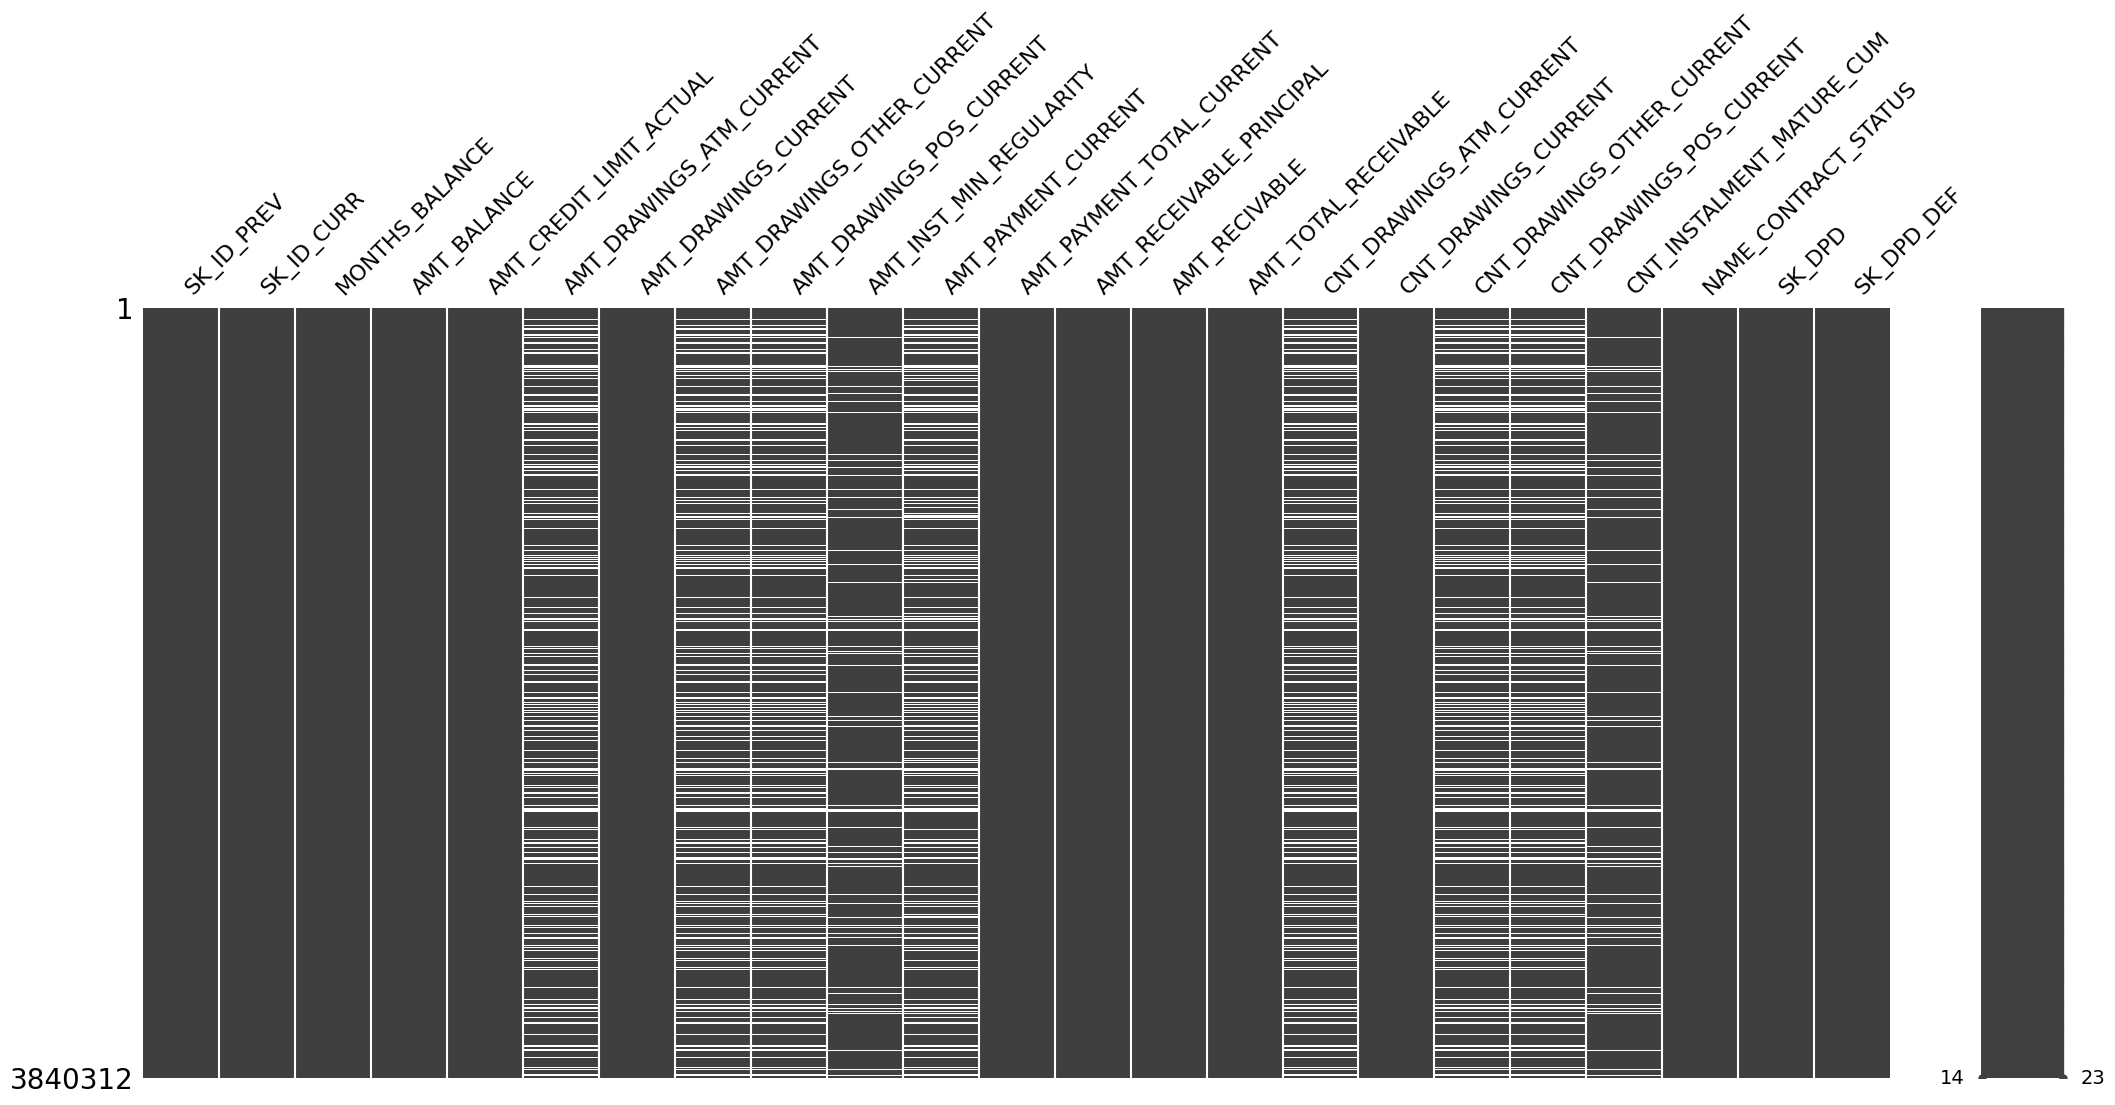

In [ ]:
msno.matrix(data_ccb)

## Installments Payments (data_ip)

In [ ]:
data_ip.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
data_ip.tail()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN
13605400,2448869,434321,1.0,19,-27.0,NaN,11504.250,NaN


In [ ]:
data_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [ ]:
nb_lignes, nb_colonnes = data_ip.shape
type_colonnes = data_ip.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 13605401
Nombre de colonnes : 8
Type des colonnes : 
float64    5
int64      3
Name: count, dtype: int64


In [ ]:
data_ip.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


 - **SK_ID_PREV** : ID du crédit précédent dans le crédit à domicile lié au prêt dans notre échantillon. (Un prêt de notre échantillon peut avoir 0, 1, 2 ou plus de prêts antérieurs dans le crédit à l'habitat)
 - **SK_ID_CURR** : ID du prêt dans notre échantillon
 - **NUM_INSTALMENT_VERSION** : Version du calendrier des versements (0 pour une carte de crédit) du crédit précédent. Le changement de la version des versements d'un mois à l'autre signifie qu'un paramètre du calendrier des paiements a changé.
 - **NUM_INSTALMENT_NUMBER** : Sur quelle échéance nous observons le paiement
 - **DAYS_INSTALMENT** : la date à laquelle le versement du crédit précédent était censé être effectué (par rapport à la date de demande du prêt actuel)
 - **DAYS_ENTRY_PAYMENT** : Quand les versements du crédit précédent ont-ils été effectivement payés (par rapport à la date de demande du prêt actuel) ?
 - **AMT_INSTALMENT** : Quel était le montant du versement prescrit du crédit précédent pour ce versement ?
 - **AMT_PAYMENT** : Ce que le client a effectivement payé sur le crédit antérieur pour ce versement

<Axes: >

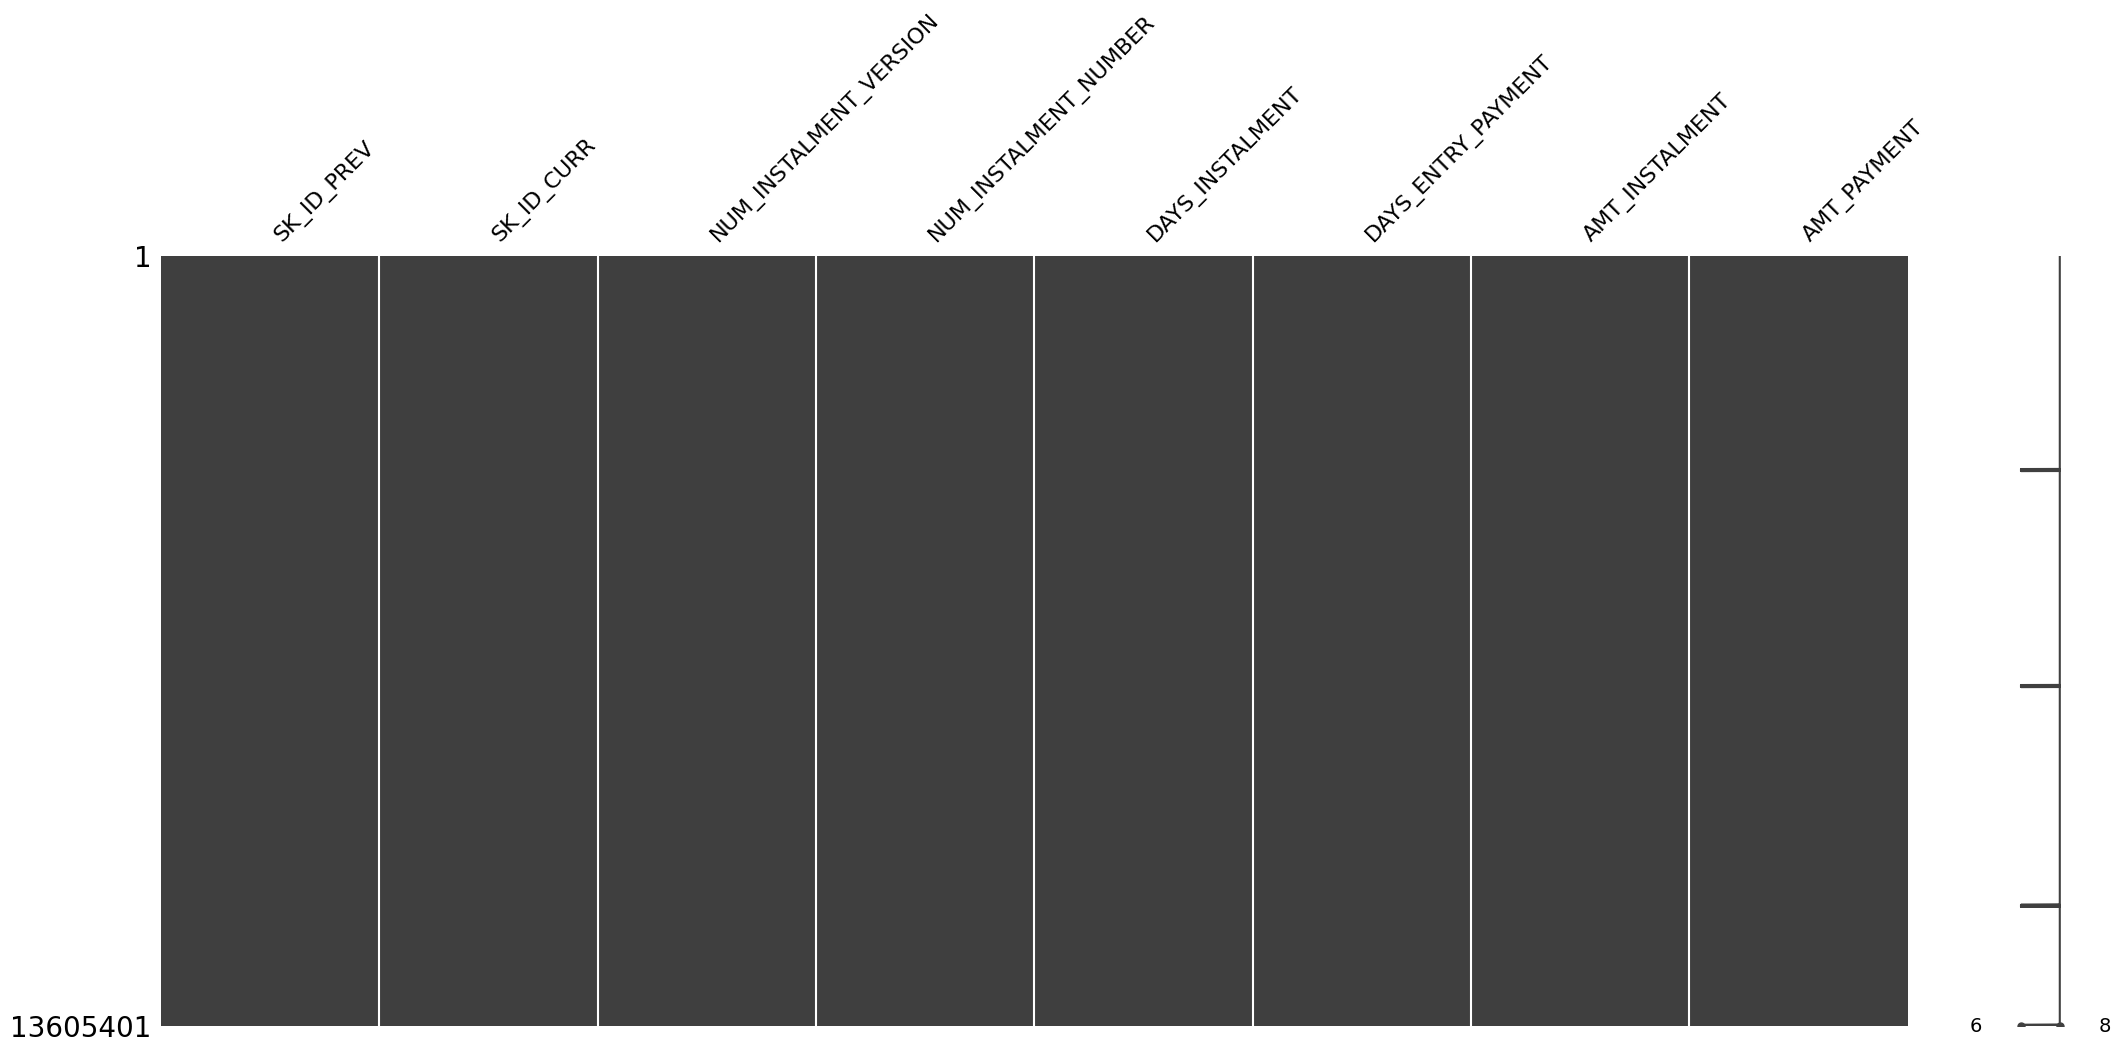

In [ ]:
msno.matrix(data_ip)

## Pos Cash Balance (data_pcb)

In [ ]:
data_pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
data_pcb.tail()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0
10001357,1259607,174278,-52,16.0,0.0,Completed,0,0


In [ ]:
data_pcb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [ ]:
nb_lignes, nb_colonnes = data_pcb.shape
type_colonnes = data_pcb.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 10001358
Nombre de colonnes : 8
Type des colonnes : 
int64      5
float64    2
object     1
Name: count, dtype: int64


In [ ]:
data_pcb.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


 - **SK_ID_PREV** : ID du crédit précédent dans Home Credit lié au prêt dans notre échantillon. (Un prêt de notre échantillon peut avoir 0,1,2 ou plus de prêts antérieurs dans Home Credit)
 - **SK_ID_CURR** : ID du prêt dans notre échantillon
 - **MONTHS_BALANCE** : Mois du solde par rapport à la date de la demande (-1 signifie que les informations correspondent à l'instantané mensuel le plus récent, 0 signifie que les informations correspondent à la date de la demande - souvent, il s'agit de -1 car de nombreuses banques ne mettent pas régulièrement à jour les informations transmises au bureau de crédit).
 - **CNT_INSTALMENT** : Durée du crédit précédent (peut changer avec le temps)
 - **CNT_INSTALMENT_FUTURE** : Les mensualités restant à payer sur le crédit précédent
 - **NAME_CONTRACT_STATUS** : Statut du contrat au cours du mois
 - **SK_DPD	DPD** : (jours de retard) pendant le mois du crédit précédent
 - **SK_DPD_DEF	DPD** : au cours du mois avec tolérance (les dettes avec un faible montant de prêt sont ignorées) du crédit précédent

<Axes: >

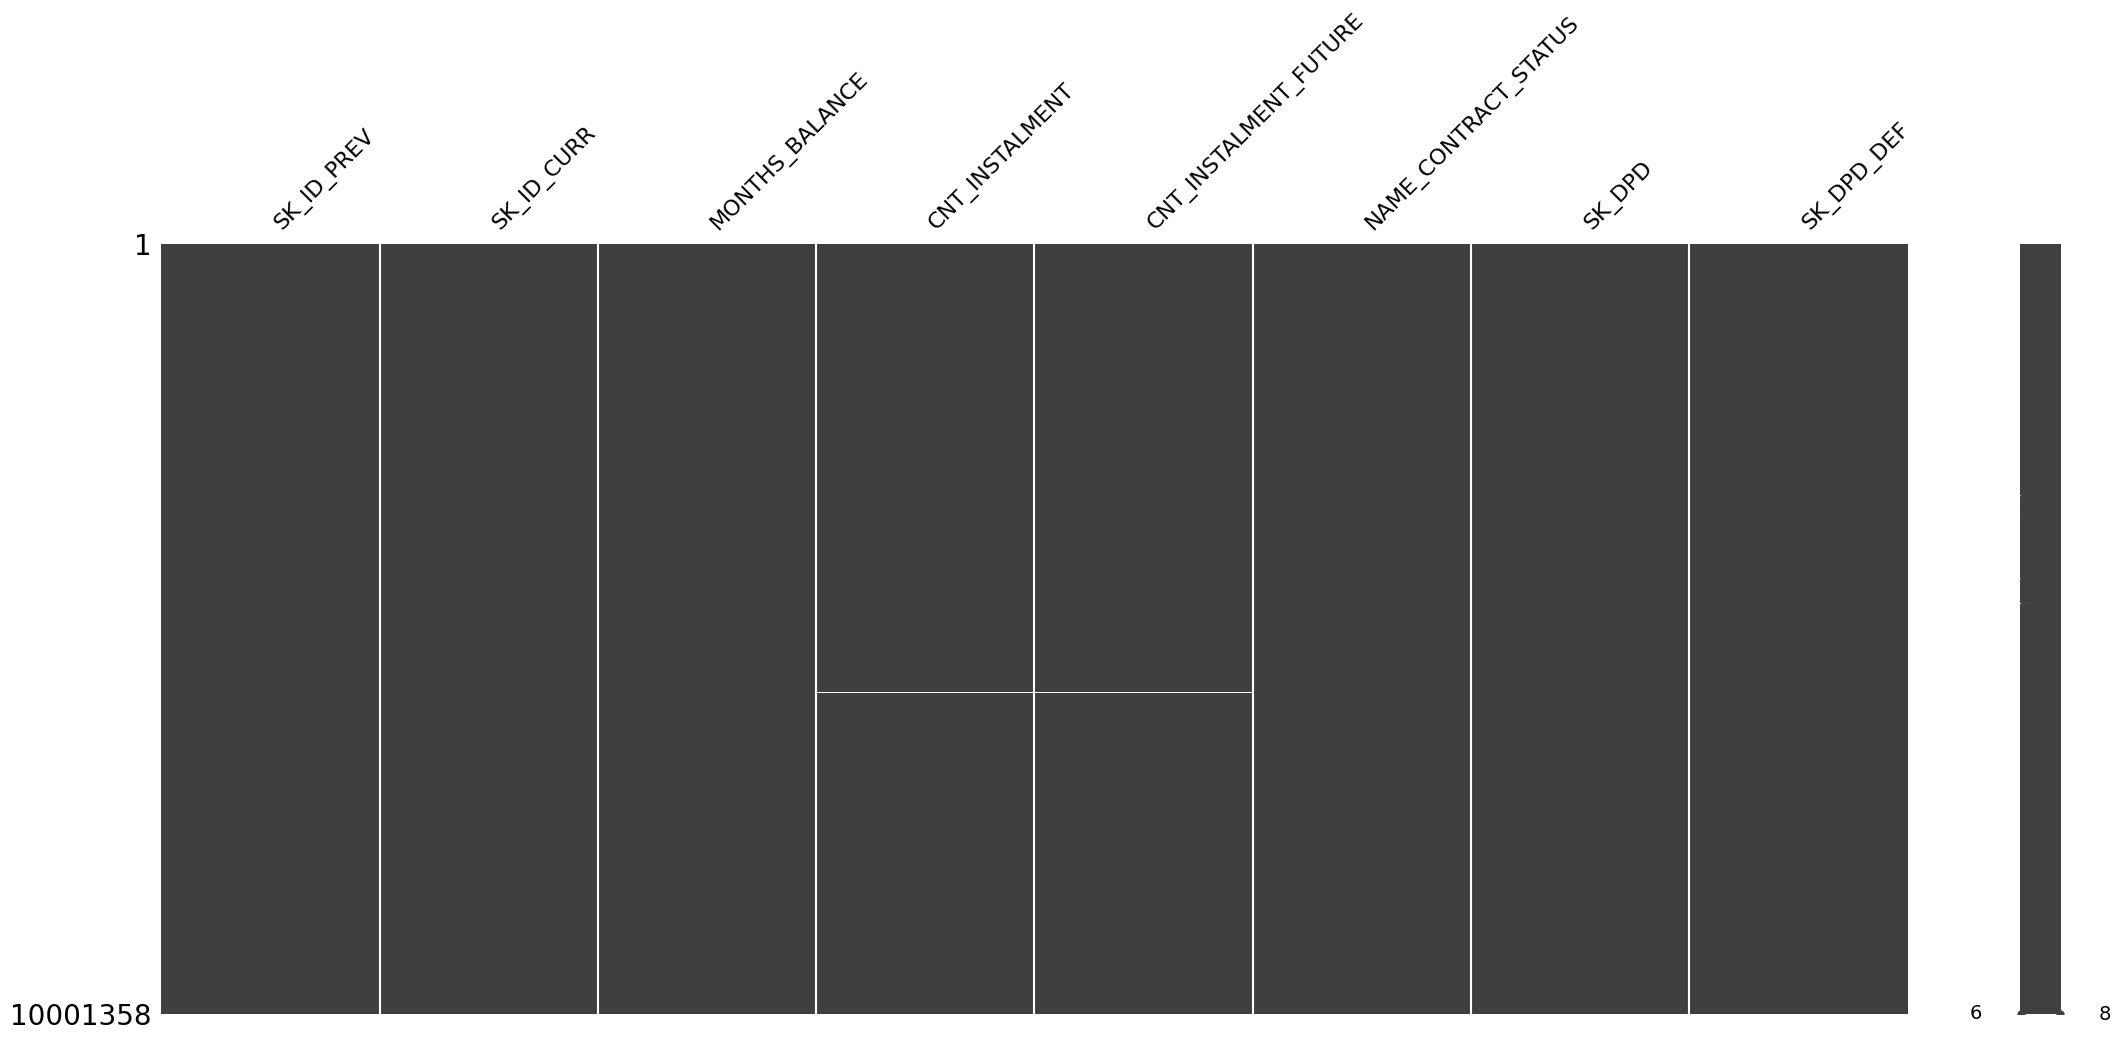

In [ ]:
msno.matrix(data_pcb)

## Previous Application (data_app)

In [ ]:
data_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_app.tail()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0
1670213,2418762,261212,Cash loans,16431.300,360000.0,360000.0,NaN,360000.0,SUNDAY,10,...,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-1163.0,247.0,-443.0,-423.0,0.0


In [ ]:
data_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [ ]:
nb_lignes, nb_colonnes = data_app.shape
type_colonnes = data_app.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 1670214
Nombre de colonnes : 37
Type des colonnes : 
object     16
float64    15
int64       6
Name: count, dtype: int64


In [ ]:
data_app.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


 - **SK_ID_PREV** : ID du crédit précédent dans le crédit à domicile lié au prêt dans notre échantillon. (Un prêt de notre échantillon peut avoir 0, 1, 2 ou plus de demandes de prêt antérieures dans le crédit immobilier, la demande antérieure peut, mais ne doit pas nécessairement, conduire à un crédit).
 - **SK_ID_CURR** : ID du prêt dans notre échantillon
 - **NAME_CONTRACT_TYPE** : Type de produit contractuel (prêt d'argent, prêt à la consommation [POS],...) de la demande précédente
 - **AMT_ANNUITY** : Annuité de la demande précédente
 - **AMT_APPLICATION** : Montant du crédit demandé par le client lors de la demande précédente
 - **AMT_CREDIT** : Montant final du crédit demandé lors de la demande précédente. Cela diffère de AMT_APPLICATION dans la mesure où AMT_APPLICATION est le montant pour lequel le client a initialement demandé, mais au cours de notre processus d'approbation, il aurait pu recevoir un montant différent - AMT_CREDIT.
 - **AMT_DOWN_PAYMENT** : Acompte sur la demande précédente
 - **AMT_GOODS_PRICE** : Prix du bien demandé par le client (le cas échéant) lors de la demande précédente
 - **WEEKDAY_APPR_PROCESS_START** : Quel jour de la semaine le client a-t-il présenté la demande précédente ?
 - **HOUR_APPR_PROCESS_START** : À quelle heure environ le client a-t-il présenté la demande précédente ?
 - **FLAG_LAST_APPL_PER_CONTRACT** : Indiquer s'il s'agit de la dernière demande pour le contrat précédent. Parfois, par erreur du client ou de notre commis, il peut y avoir plusieurs demandes pour un seul contrat.
 - **NFLAG_LAST_APPL_IN_DAY** : Indiquer si la demande était la dernière demande par jour du client. Il arrive que les clients fassent plus de demandes par jour. Dans de rares cas, il peut s'agir d'une erreur de notre système qui fait qu'une demande se trouve deux fois dans la base de données.
 - **NFLAG_MICRO_CASH** : Drapeau Prêt microfinancier
 - **RATE_DOWN_PAYMENT** : Taux d'acompte normalisé en fonction du crédit antérieur
 - **RATE_INTEREST_PRIMARY** : Taux d'intérêt normalisé sur le crédit antérieur
 - **RATE_INTEREST_PRIVILEGED** : Taux d'intérêt normalisé sur le crédit précédent
 - **NAME_CASH_LOAN_PURPOSE** : Objet du prêt d'argent
 - **NAME_CONTRACT_STATUS** : Statut du contrat (approuvé, annulé, ...) de la demande précédente
 - **DAYS_DECISION** : Par rapport à la demande actuelle, quand la décision concernant la demande précédente a-t-elle été prise ?
 - **NAME_PAYMENT_TYPE** : Mode de paiement choisi par le client pour régler la demande précédente
 - **CODE_REJECT_REASON** : Pourquoi la demande précédente a-t-elle été rejetée ?
 - **NAME_TYPE_SUITE** : Qui a accompagné le client lors de l'introduction de la demande précédente
 - **NAME_CLIENT_TYPE** : Le client était-il un ancien ou un nouveau client lors de la demande précédente ?
 - **NAME_GOODS_CATEGORY** : Quel type de biens le client a-t-il demandé lors de la demande précédente ?
 - **NAME_PORTFOLIO** : La demande précédente concernait-elle des produits CASH, POS, CAR, ...
 - **NAME_PRODUCT_TYPE** : La demande précédente concernait-elle la vente à l'étalage ou la vente à pied ?
 - **CHANNEL_TYPE** : Par quel canal avons-nous acquis le client lors de la demande précédente ?
 - **SELLERPLACE_AREA** : Zone de vente du vendeur sur le lieu de la demande précédente
 - **NAME_SELLER_INDUSTRY** : Le secteur d'activité du vendeur
 - **CNT_PAYMENT** : Durée du crédit précédent au moment de la demande de la demande précédente
 - **NAME_YIELD_GROUP** : Taux d'intérêt groupé en taux faible, moyen et élevé de la demande précédente
 - **PRODUCT_COMBINATION** : Combinaison détaillée de produits de la demande précédente
 - **DAYS_FIRST_DRAWING** : Par rapport à la date de dépôt de la demande actuelle, quand le premier versement de la demande précédente a-t-il eu lieu ?
 - **DAYS_FIRST_DUE** : Par rapport à la date de la demande actuelle, date de la première échéance supposée de la demande précédente
 - **DAYS_LAST_DUE_1ST_VERSION** : Par rapport à la date de la demande actuelle, date de la première échéance de la demande précédente
 - **DAYS_LAST_DUE** : Par rapport à la date de la demande actuelle, date de la dernière échéance de la demande précédente
 - **DAYS_TERMINATION** : Par rapport à la date de la demande actuelle, quand la demande précédente a-t-elle pris fin ?
 - **NFLAG_INSURED_ON_APPROVAL** : Le client a-t-il demandé une assurance lors de la demande précédente ?

<Axes: >

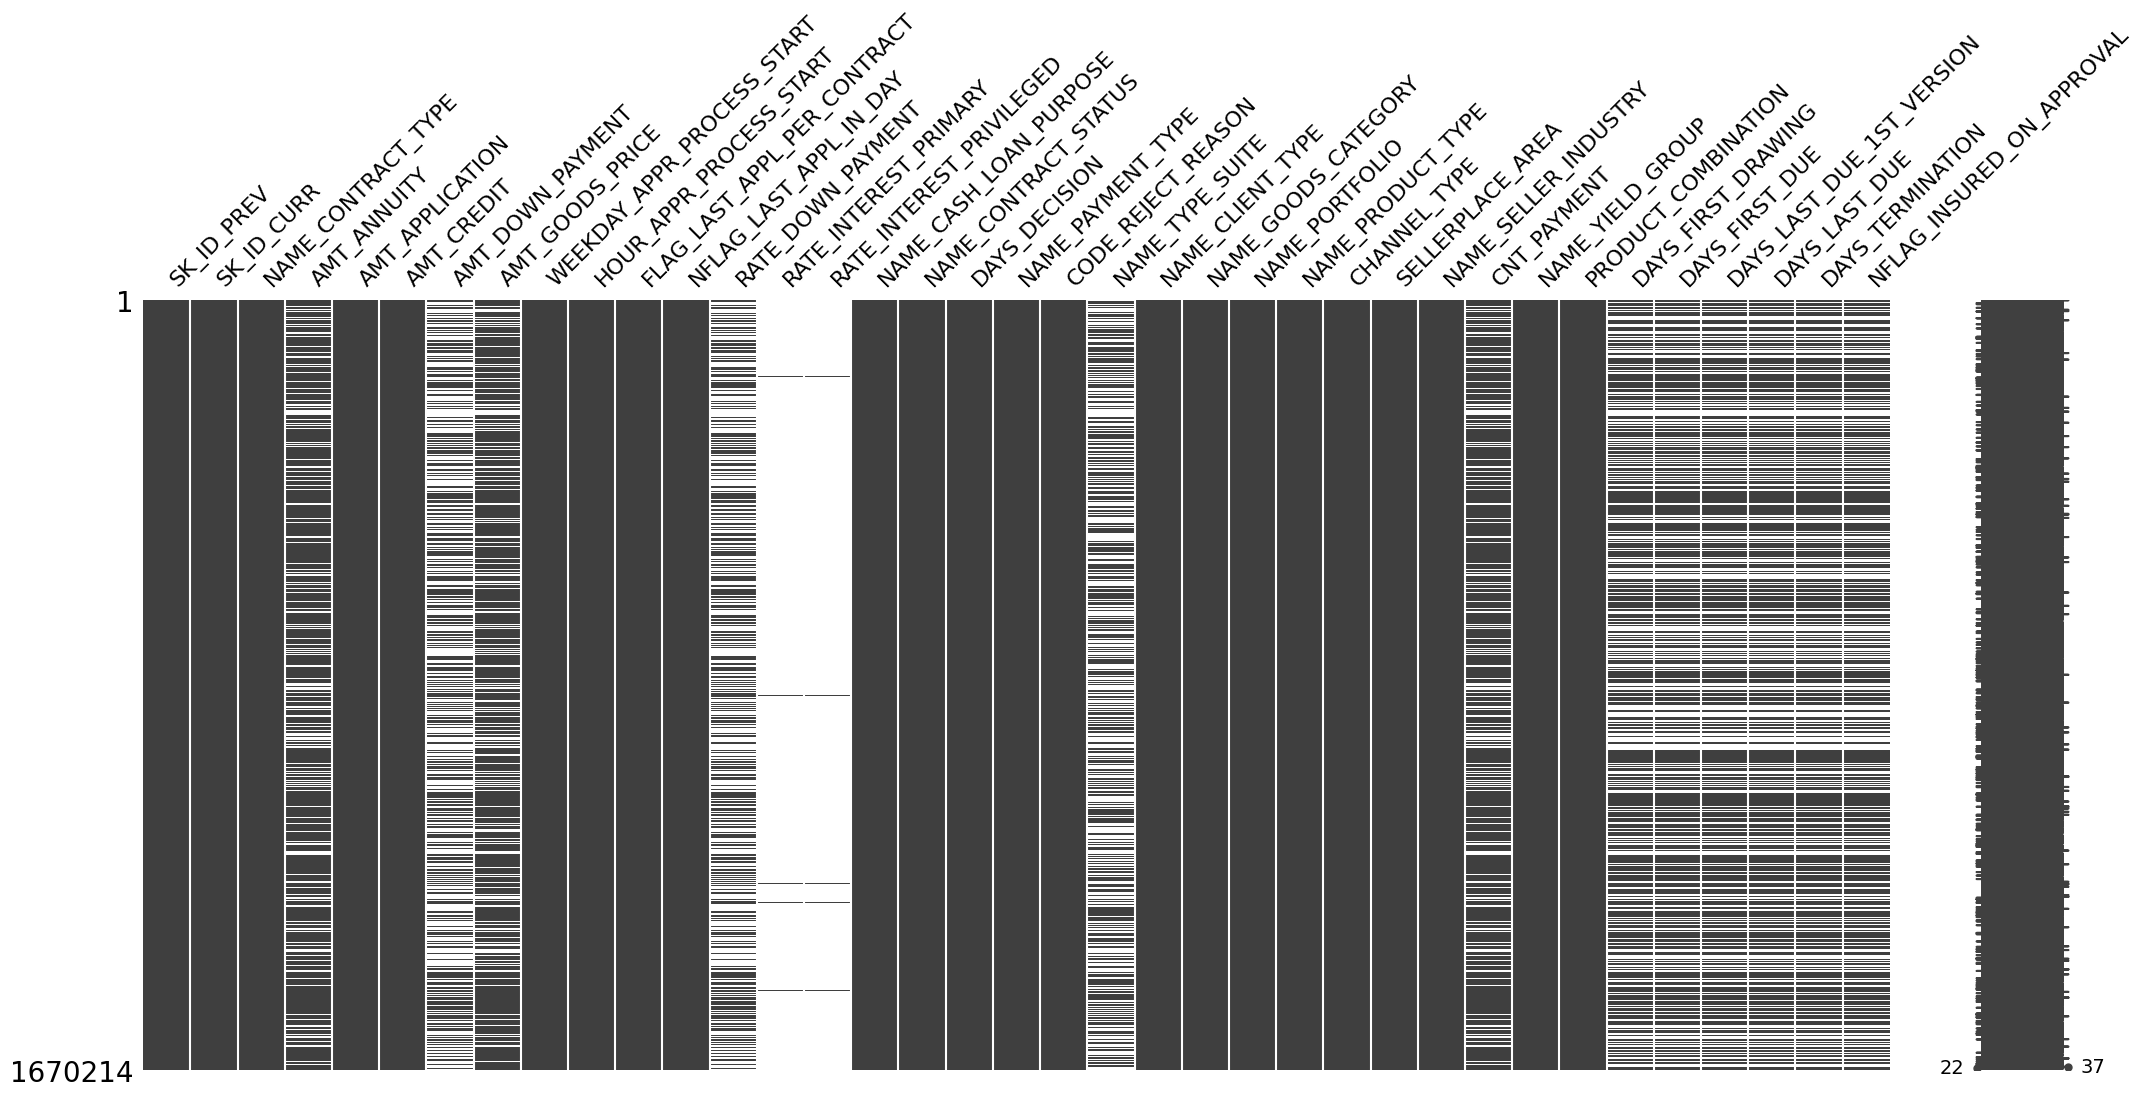

In [ ]:
msno.matrix(data_app)

In [ ]:
data_test.columns.tolist()

['SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEAR

In [ ]:
data_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

Notre modèle devra prédire la variable "Target", celle-ci est présente dans le fichier d'entrainement mais pas dans le fichier test.

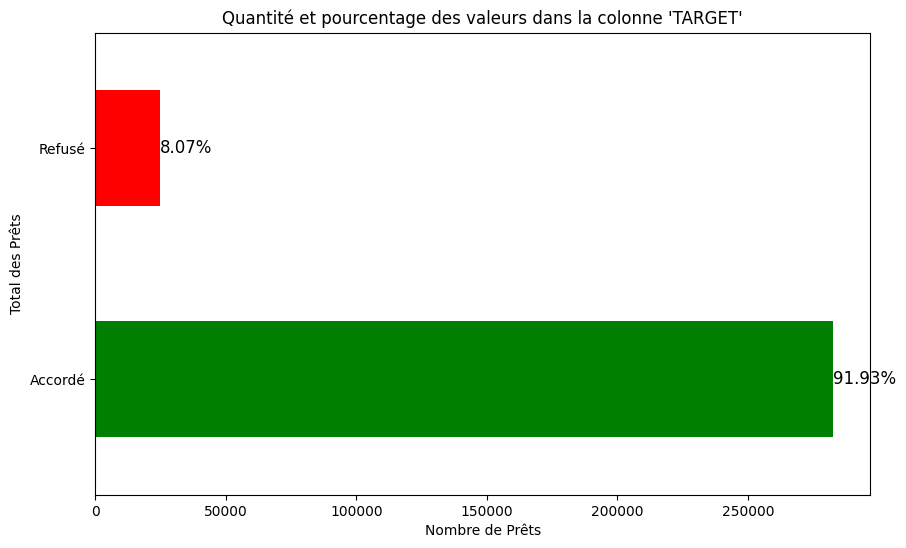

In [ ]:
# Calcul des valeurs
quantites = data_train["TARGET"].value_counts()
pourcentages = data_train["TARGET"].value_counts(normalize=True) * 100

# Création du Barplot
plt.figure(figsize=(10, 6))
barplot = quantites.plot(kind="barh", color=["green", "red"])

# Changement des étiquettes 0 et 1 par oui et non
barplot.set_yticklabels(["Accordé" if x == 0 else "Refusé" for x in quantites.index])

# Complément d'informations pour le graphique
for i in range(len(quantites)):
    plt.text(quantites[i], i, f"{pourcentages[i]:.2f}%", va="center", ha="left", fontsize=12)

plt.title("Quantité et pourcentage des valeurs dans la colonne 'TARGET'")
plt.xlabel("Nombre de Prêts")
plt.ylabel("Total des Prêts")
plt.show()

# <center>Feature Engineering</enter>

## Part 1 - Assemblage des données

### Application Train & Application Test

In [ ]:
# Merge "data_train" avec "data_test"
data = data_train.copy()

In [ ]:
# Vue rapide sur les datasets
print("Dataset Train:" + str(data_train.shape))
print("Dataset Test:" + str(data_test.shape))
print("Data:" + str(data.shape))

Dataset Train:(307507, 122)
Dataset Test:(48744, 121)
Data:(307507, 122)


In [ ]:
# Visualisation des valeurs manquante dans "Target"
print(f"Il y a {data.TARGET.isna().sum()} valeurs manquantes dans la colonne TARGET.")

Il y a 0 valeurs manquantes dans la colonne TARGET.


- Les 48744 valeurs manquantes dans la colonne "Target" correspondent au nombre de ligne du dataset "data_test" qui ne comporte pas de "Target"

### Data & Bureau

#### - Calcul des crédits précédents pris par client

In [ ]:
# Vue rapide sur le dataset
print("Dataset Bureau:" + str(data_bureau.shape))

Dataset Bureau:(1716428, 17)


In [ ]:
# Calcul du nombres de prêt précédents de chaque client
number_previous_loans = data_bureau.groupby("SK_ID_CURR", as_index=False)["SK_ID_BUREAU"].count().rename(columns = {"SK_ID_BUREAU": "NUMBER_PREVIOUS_LOANS"})
number_previous_loans

,SK_ID_CURR,NUMBER_PREVIOUS_LOANS
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


In [ ]:
# Ajout de la colonne "number_previous_loans" au DataFrame "Data"
data = data.merge(number_previous_loans, on="SK_ID_CURR", how="left")

In [ ]:
# Vue rapide sur le dataset
print("Data:" + str(data.shape))

Data:(307507, 123)


### Bureau & Bureau Balance = Bureaux

#### - Solde Mensuel moyen par clients

In [ ]:
# Vue rapide sur le dataset
print("Dataset Bureau Balance:" + str(data_bb.shape))

Dataset Bureau Balance:(27299925, 3)


In [ ]:
# Soldes mensuels moyen des crédits
mean_bb = data_bb.drop(columns=["STATUS"]).groupby("SK_ID_BUREAU", as_index=False).mean()

# Renommage de la colonne MONTHS_BALANCE en MONTHS_BALANCE_MEAN
mean_bb = mean_bb.rename(columns={"MONTHS_BALANCE": "MONTHS_BALANCE_MEAN"})
mean_bb

,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5
...,...,...
817390,6842884,-23.5
817391,6842885,-11.5
817392,6842886,-16.0
817393,6842887,-18.0


In [ ]:
# Merge data_bureau & mean_bb
data_bureau_final = data_bureau.merge(mean_bb, on="SK_ID_BUREAU", how="left")

# Suppression de la colonne inutile
data_bureau_final.drop("SK_ID_BUREAU", axis=1, inplace=True)
data_bureau_final

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN,NaN
1716424,100044,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN,NaN
1716425,100044,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN,NaN
1716426,246829,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN,NaN


In [ ]:
# Sélection des colonne numérique
numeric_columns = data_bureau_final.select_dtypes(include=["number"]).columns

# Calcul de la moyenne par groupe et ajout préfixe
data_mean_bureau = data_bureau_final.groupby("SK_ID_CURR", as_index=False)[numeric_columns].mean().add_prefix("PREV_DESK_MEAN_")

# Renommage de l'id
data_mean_bureau.rename(columns={"PREV_DESK_MEAN_SK_ID_CURR": "SK_ID_CURR"}, inplace=True)
data_mean_bureau


,SK_ID_CURR,PREV_DESK_MEAN_DAYS_CREDIT,PREV_DESK_MEAN_CREDIT_DAY_OVERDUE,PREV_DESK_MEAN_DAYS_CREDIT_ENDDATE,PREV_DESK_MEAN_DAYS_ENDDATE_FACT,PREV_DESK_MEAN_AMT_CREDIT_MAX_OVERDUE,PREV_DESK_MEAN_CNT_CREDIT_PROLONG,PREV_DESK_MEAN_AMT_CREDIT_SUM,PREV_DESK_MEAN_AMT_CREDIT_SUM_DEBT,PREV_DESK_MEAN_AMT_CREDIT_SUM_LIMIT,PREV_DESK_MEAN_AMT_CREDIT_SUM_OVERDUE,PREV_DESK_MEAN_DAYS_CREDIT_UPDATE,PREV_DESK_MEAN_AMT_ANNUITY,PREV_DESK_MEAN_MONTHS_BALANCE_MEAN
0,100001.0,-735.000000,0.0,82.428571,-825.500000,NaN,0.000000,2.076236e+05,85240.928571,0.00000,0.0,-93.142857,3545.357143,-11.785714
1,100002.0,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.000000,1.081319e+05,49156.200000,7997.14125,0.0,-499.875000,0.000000,-21.875000
2,100003.0,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.000000,2.543501e+05,0.000000,202500.00000,0.0,-816.000000,NaN,NaN
3,100004.0,-867.000000,0.0,-488.500000,-532.500000,0.000,0.000000,9.451890e+04,0.000000,0.00000,0.0,-532.000000,NaN,NaN
4,100005.0,-190.666667,0.0,439.333333,-123.000000,0.000,0.000000,2.190420e+05,189469.500000,0.00000,0.0,-54.333333,1420.500000,-3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249.0,-1667.076923,0.0,-1232.333333,-1364.750000,6147.000,0.000000,2.841430e+05,16307.100000,0.00000,0.0,-1064.538462,NaN,NaN
305807,456250.0,-862.000000,0.0,1288.333333,-760.000000,0.000,0.000000,1.028820e+06,744013.365000,19422.79500,0.0,-60.333333,154567.965000,-14.000000
305808,456253.0,-867.500000,0.0,280.500000,-794.000000,NaN,0.000000,9.900000e+05,448958.250000,0.00000,0.0,-253.250000,58369.500000,-14.125000
305809,456254.0,-1104.000000,0.0,-859.000000,-859.000000,NaN,0.000000,4.500000e+04,0.000000,NaN,0.0,-401.000000,0.000000,-18.000000


- Ajout de 13 colonnes supplémentaire dans notre dataset

### Data & Bureaux

In [ ]:
# Ajout de la colonne "data_mean_bureau" au DataFrame "Data"
data = data.merge(data_mean_bureau, on="SK_ID_CURR", how="left")
print("Data:" + str(data.shape))

Data:(307507, 136)


### Previous Application & autre

#### - Nombre de demandes de crédit immobilier

In [ ]:
# Vue rapide sur le dataset
print("Dataset Previous Application:" + str(data_app.shape))

Dataset Previous Application:(1670214, 37)


In [ ]:
# Calcul des demandes antérieurs au crédit immobilier
number_previous_app = data_app.groupby("SK_ID_CURR", as_index=False)["SK_ID_PREV"].count().rename(columns = {"SK_ID_PREV": "NUMBER_PREVIOUS_APPLICATION"})
number_previous_app

,SK_ID_CURR,NUMBER_PREVIOUS_APPLICATION
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2
...,...,...
338852,456251,1
338853,456252,1
338854,456253,2
338855,456254,2


In [ ]:
# Ajout de la colonne "number_previous_app" au DataFrame "Data"
data = data.merge(number_previous_app, on="SK_ID_CURR", how="left")
print("Data:" + str(data.shape))

Data:(307507, 137)


#### Previous Application & Crédit Card Balance

In [ ]:
# Vue rapide sur le dataset
print("Dataset Crédit Card:" + str(data_ccb.shape))

Dataset Crédit Card:(3840312, 23)


In [ ]:
# Drop de la colonne "SK_ID_CURR"
data_ccb.drop("SK_ID_CURR", axis=1, inplace=True)

# Sélection des colonne numérique
numeric_columns = data_ccb.select_dtypes(include=["number"]).columns

# Calcul de la moyenne par groupe et ajout préfixe
ccb_mean = data_ccb.groupby("SK_ID_PREV", as_index=False)[numeric_columns].mean().add_prefix("CC_MEAN_")

# Renommage de l'id
ccb_mean.rename(columns = {"CC_MEAN_SK_ID_PREV" : "SK_ID_PREV"}, inplace=True)
ccb_mean

,SK_ID_PREV,CC_MEAN_MONTHS_BALANCE,CC_MEAN_AMT_BALANCE,CC_MEAN_AMT_CREDIT_LIMIT_ACTUAL,CC_MEAN_AMT_DRAWINGS_ATM_CURRENT,CC_MEAN_AMT_DRAWINGS_CURRENT,CC_MEAN_AMT_DRAWINGS_OTHER_CURRENT,CC_MEAN_AMT_DRAWINGS_POS_CURRENT,CC_MEAN_AMT_INST_MIN_REGULARITY,CC_MEAN_AMT_PAYMENT_CURRENT,...,CC_MEAN_AMT_RECEIVABLE_PRINCIPAL,CC_MEAN_AMT_RECIVABLE,CC_MEAN_AMT_TOTAL_RECEIVABLE,CC_MEAN_CNT_DRAWINGS_ATM_CURRENT,CC_MEAN_CNT_DRAWINGS_CURRENT,CC_MEAN_CNT_DRAWINGS_OTHER_CURRENT,CC_MEAN_CNT_DRAWINGS_POS_CURRENT,CC_MEAN_CNT_INSTALMENT_MATURE_CUM,CC_MEAN_SK_DPD,CC_MEAN_SK_DPD_DEF
0,1000018.0,-4.0,74946.285000,81000.000000,5400.000000,29478.996000,0.0,24078.996000,2594.088000,5541.750000,...,72298.197000,73602.585000,73602.585000,1.200000,8.800000,0.0,7.600000,2.000000,0.000000,0.000000
1,1000030.0,-4.5,55991.064375,81562.500000,642.857143,17257.438125,0.0,19079.929286,2078.223750,6188.631429,...,55474.453125,55935.376875,55935.376875,0.142857,5.125000,0.0,5.714286,1.875000,0.000000,0.000000
2,1000031.0,-8.5,52394.439375,149625.000000,12115.384615,28959.615000,0.0,23527.218462,2675.300625,29543.257500,...,51402.878437,52099.970625,52099.970625,0.307692,1.312500,0.0,1.307692,3.687500,0.000000,0.000000
3,1000035.0,-4.0,0.000000,225000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
4,1000077.0,-7.0,0.000000,94090.909091,NaN,0.000000,NaN,NaN,0.000000,NaN,...,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104302,2843476.0,-49.0,37937.812263,161526.315789,947.368421,947.368421,0.0,0.000000,3443.780368,3467.420053,...,35958.626053,38133.234947,38332.182316,0.021053,0.021053,0.0,0.000000,33.989474,15.031579,3.473684
104303,2843477.0,-43.0,1663.076647,15882.352941,688.235294,688.235294,0.0,0.000000,123.165000,955.265294,...,1560.223588,1644.714529,1644.714529,0.070588,0.070588,0.0,0.000000,3.928571,0.000000,0.000000
104304,2843478.0,-46.5,5111.405000,21000.000000,1000.000000,1000.000000,0.0,0.000000,455.374719,1355.795000,...,4891.073500,5097.742000,5097.742000,0.044444,0.044444,0.0,0.000000,9.494382,0.000000,0.000000
104305,2843493.0,-8.0,59139.927000,153000.000000,0.000000,7217.160000,0.0,7732.671429,2820.528000,5625.927692,...,56730.900000,58384.818000,58384.818000,0.000000,0.466667,0.0,0.500000,6.066667,0.000000,0.000000


In [ ]:
# Fusion Crédit Card Mean avec data_app
data_app = data_app.merge(ccb_mean, on="SK_ID_PREV", how="left")

In [ ]:
# Vue rapide sur le dataset
print("Dataset Previous Application:" + str(data_app.shape))

Dataset Previous Application:(1670214, 57)


#### Previous Application & Installments Payments

In [ ]:
# Vue rapide sur le dataset
print("Dataset Installments Payments:" + str(data_ip.shape))

Dataset Installments Payments:(13605401, 8)


In [ ]:
# Drop de la colonne "SK_ID_CURR"
data_ip.drop("SK_ID_CURR", axis=1, inplace=True)

# Sélection des colonne numérique
numeric_columns = data_ip.select_dtypes(include=["number"]).columns

# Calcul de la moyenne par groupe et ajout préfixe
install_pay_mean = data_ip.groupby("SK_ID_PREV", as_index=False)[numeric_columns].mean().add_prefix("INSTALL_MEAN_")

# Renommage de l'id
install_pay_mean.rename(columns = {"INSTALL_MEAN_SK_ID_PREV" : "SK_ID_PREV"}, inplace=True)
install_pay_mean

,SK_ID_PREV,INSTALL_MEAN_NUM_INSTALMENT_VERSION,INSTALL_MEAN_NUM_INSTALMENT_NUMBER,INSTALL_MEAN_DAYS_INSTALMENT,INSTALL_MEAN_DAYS_ENTRY_PAYMENT,INSTALL_MEAN_AMT_INSTALMENT,INSTALL_MEAN_AMT_PAYMENT
0,1000001.0,1.500000,1.500000,-253.000000,-269.000000,34221.712500,34221.712500
1,1000002.0,1.250000,2.500000,-1555.000000,-1574.750000,9308.891250,9308.891250
2,1000003.0,1.000000,2.000000,-64.000000,-79.333333,4951.350000,4951.350000
3,1000004.0,1.142857,4.000000,-772.000000,-798.714286,4789.022143,4789.022143
4,1000005.0,1.000000,5.818182,-1543.454545,-1551.909091,14703.210000,13365.609545
...,...,...,...,...,...,...,...
997747,2843495.0,1.142857,4.000000,-349.000000,-352.857143,113932.883571,113932.883571
997748,2843496.0,0.000000,16.235294,-258.058824,-262.058824,9186.311912,8950.975147
997749,2843497.0,1.000000,10.500000,-303.000000,-305.900000,9175.185000,9175.185000
997750,2843498.0,1.333333,3.500000,-1367.666667,-1380.333333,69053.572500,69053.572500


In [ ]:
# Fusion Install Pay Mean avec Previous Application
data_app = data_app.merge(install_pay_mean, on="SK_ID_PREV", how="left")

In [ ]:
# Vue rapide sur le dataset
print("Dataset Previous Application:" + str(data_app.shape))

Dataset Previous Application:(1670214, 63)


#### Installments Payments & POS CASH Balance

In [ ]:
# Drop de la colonne "SK_ID_CURR"
data_pcb.drop("SK_ID_CURR", axis=1, inplace=True)

# Sélection des colonne numérique
numeric_columns = data_pcb.select_dtypes(include=["number"]).columns

# Calcul de la moyenne par groupe et ajout préfixe
pcb_mean = data_pcb.groupby("SK_ID_PREV", as_index=False)[numeric_columns].mean().add_prefix("POS_MEAN_")

# Renommage de l'id
pcb_mean.rename(columns = {"POS_MEAN_SK_ID_PREV" : "SK_ID_PREV"}, inplace=True)
pcb_mean

,SK_ID_PREV,POS_MEAN_MONTHS_BALANCE,POS_MEAN_CNT_INSTALMENT,POS_MEAN_CNT_INSTALMENT_FUTURE,POS_MEAN_SK_DPD,POS_MEAN_SK_DPD_DEF
0,1000001.0,-9.0,8.666667,7.666667,0.0,0.0
1,1000002.0,-52.0,5.200000,2.000000,0.0,0.0
2,1000003.0,-2.5,12.000000,10.500000,0.0,0.0
3,1000004.0,-25.5,9.625000,6.125000,0.0,0.0
4,1000005.0,-51.0,10.000000,5.000000,0.0,0.0
...,...,...,...,...,...,...
936320,2843494.0,-25.0,32.666667,31.666667,0.0,0.0
936321,2843495.0,-12.5,53.375000,49.875000,0.0,0.0
936322,2843497.0,-11.0,24.000000,14.000000,0.0,0.0
936323,2843498.0,-45.0,27.428571,24.285714,0.0,0.0


#### POS CASH Balance & Previous Application

In [ ]:
# Fusion pcb_mean avec Previous Application
data_app = data_app.merge(pcb_mean, on="SK_ID_PREV", how="left")
data_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,INSTALL_MEAN_NUM_INSTALMENT_NUMBER,INSTALL_MEAN_DAYS_INSTALMENT,INSTALL_MEAN_DAYS_ENTRY_PAYMENT,INSTALL_MEAN_AMT_INSTALMENT,INSTALL_MEAN_AMT_PAYMENT,POS_MEAN_MONTHS_BALANCE,POS_MEAN_CNT_INSTALMENT,POS_MEAN_CNT_INSTALMENT_FUTURE,POS_MEAN_SK_DPD,POS_MEAN_SK_DPD_DEF
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,1.000000,-42.000000,-42.000000,17284.275000,17284.275000,-1.5,6.500000,6.000000,0.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,3.000000,-74.000000,-83.200000,25188.615000,25188.615000,-4.0,36.000000,34.000000,0.0,0.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,5.000000,-151.000000,-159.222222,15060.735000,15060.735000,-5.5,12.000000,7.500000,0.0,0.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,6.000000,-332.000000,-339.090909,51193.943182,51193.943182,-11.5,11.916667,6.416667,0.0,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,3.500000,-433.000000,-441.166667,58960.597500,58960.597500,-14.5,24.000000,21.375000,0.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,6.000000,-1454.000000,-1504.090909,7206.533182,7206.533182,-49.0,11.923077,6.846154,0.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,...,5.500000,-1322.000000,-1325.900000,11518.857000,11518.857000,-44.0,10.000000,5.000000,0.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,...,6.500000,-990.000000,-1002.916667,18819.555000,18819.555000,-32.0,12.000000,5.153846,0.0,0.0


### Data & Previous Application

In [ ]:
# Sélection des colonne numérique
numeric_columns = data_app.select_dtypes(include=["number"]).columns

# Calcul de la moyenne par groupe et ajout préfixe
prev_app_mean = data_app.groupby("SK_ID_CURR", as_index=False)[numeric_columns].mean().add_prefix("PREV_APP_MEAN_")

# Renommage de l'id
prev_app_mean.rename(columns = {"PREV_APP_MEAN_SK_ID_CURR" : "SK_ID_CURR"}, inplace=True)

# Suppression de la colonne
prev_app_mean = prev_app_mean.drop("PREV_APP_MEAN_SK_ID_PREV", axis=1)
prev_app_mean

,SK_ID_CURR,PREV_APP_MEAN_AMT_ANNUITY,PREV_APP_MEAN_AMT_APPLICATION,PREV_APP_MEAN_AMT_CREDIT,PREV_APP_MEAN_AMT_DOWN_PAYMENT,PREV_APP_MEAN_AMT_GOODS_PRICE,PREV_APP_MEAN_HOUR_APPR_PROCESS_START,PREV_APP_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APP_MEAN_RATE_DOWN_PAYMENT,PREV_APP_MEAN_RATE_INTEREST_PRIMARY,...,PREV_APP_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER,PREV_APP_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APP_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APP_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APP_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APP_MEAN_POS_MEAN_MONTHS_BALANCE,PREV_APP_MEAN_POS_MEAN_CNT_INSTALMENT,PREV_APP_MEAN_POS_MEAN_CNT_INSTALMENT_FUTURE,PREV_APP_MEAN_POS_MEAN_SK_DPD,PREV_APP_MEAN_POS_MEAN_SK_DPD_DEF
0,100001.0,3951.000000,24835.500,23787.00,2520.00,24835.500,13.000000,1.0,0.104326,NaN,...,2.500000,-1664.000000,-1679.500000,7312.725000,7312.725000,-55.000000,4.000000,2.000000,0.000000,0.000000
1,100002.0,9251.775000,179055.000,179055.00,0.00,179055.000,9.000000,1.0,0.000000,NaN,...,10.000000,-295.000000,-315.421053,11559.247105,11559.247105,-10.000000,24.000000,15.000000,0.000000,0.000000
2,100003.0,56553.990000,435436.500,484191.00,3442.50,435436.500,14.666667,1.0,0.050030,NaN,...,4.666667,-1164.333333,-1171.781746,78558.479286,78558.479286,-39.166667,9.791667,5.666667,0.000000,0.000000
3,100004.0,5357.250000,24282.000,20106.00,4860.00,24282.000,5.000000,1.0,0.212008,NaN,...,2.000000,-754.000000,-761.666667,7096.155000,7096.155000,-25.500000,3.750000,2.250000,0.000000,0.000000
4,100005.0,4813.200000,22308.750,20076.75,4464.00,44617.500,10.500000,1.0,0.108964,NaN,...,5.000000,-586.000000,-609.555556,6240.205000,6240.205000,-20.000000,11.700000,7.200000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251.0,6605.910000,40455.000,40455.00,0.00,40455.000,17.000000,1.0,0.000000,NaN,...,4.000000,-120.000000,-156.285714,7492.924286,7492.924286,-5.000000,7.875000,4.375000,0.000000,0.000000
338853,456252.0,10074.465000,57595.500,56821.50,3456.00,57595.500,10.000000,1.0,0.062443,NaN,...,3.500000,-2391.000000,-2393.833333,10069.867500,10069.867500,-79.000000,6.000000,3.000000,0.000000,0.000000
338854,456253.0,4770.405000,24162.750,20625.75,4403.25,24162.750,11.500000,1.0,0.214316,NaN,...,3.050000,-2277.500000,-2295.466667,4770.906000,4373.596500,-75.750000,5.000000,2.333333,0.416667,0.416667
338855,456254.0,10681.132500,121317.750,134439.75,0.00,121317.750,15.000000,1.0,0.000000,NaN,...,5.250000,-141.500000,-160.111111,10681.132500,10681.132500,-5.500000,15.000000,10.500000,0.000000,0.000000


In [ ]:
print("Data:" + str(data.shape))

Data:(307507, 137)


In [ ]:
# Fusion prev_app_mean avec data
data = data.merge(prev_app_mean, on="SK_ID_CURR", how="left")

In [ ]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307507
Nombre de colonnes : 187
Type des colonnes : 
float64    131
int64       40
object      16
Name: count, dtype: int64


##### Ajout de nouvelles variables

1
- Taux d'endetement du client

In [ ]:
# Création d'une première variable : Debt Income Ratio
data["DTI"] = data["AMT_CREDIT"] / data["AMT_INCOME_TOTAL"]

2
- Durée du paiement

In [ ]:
# Création d'une seconde variable :# Loan Term
data["LOAN_TERM"] = data["AMT_ANNUITY"] / data["AMT_CREDIT"]

3
- Revenu divisé par le nombre de membres dans la famille

In [ ]:
# Création d'une troisième variable : Income Family Member
data["IFM"] = data["AMT_INCOME_TOTAL"] / data["CNT_FAM_MEMBERS"]

## Part 2 - Encodage / Standardisation

In [ ]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307507
Nombre de colonnes : 190
Type des colonnes : 
float64    134
int64       40
object      16
Name: count, dtype: int64


In [ ]:
"""
le = LabelEncoder()
count = 0

# Réencodage des colonnes "Object"
for col in data:
    # Si 2 valeurs uniques ou moins
    if data.loc[:,col].dtype == "object" and len(list(data.loc[:,col].unique())) <= 2:
        # Apprentissage sur les données data
        le.fit(data.loc[:,col])
        # Transformer les données data
        data.loc[:,col] = le.transform(data.loc[:,col])
        count += 1

print('%d colonnes ont été codées.' % count)
"""

'\nle = LabelEncoder()\ncount = 0\n\n# Réencodage des colonnes "Object"\nfor col in data:\n    # Si 2 valeurs uniques ou moins\n    if data.loc[:,col].dtype == "object" and len(list(data.loc[:,col].unique())) <= 2:\n        # Apprentissage sur les données data\n        le.fit(data.loc[:,col])\n        # Transformer les données data\n        data.loc[:,col] = le.transform(data.loc[:,col])\n        count += 1\n\nprint(\'%d colonnes ont été codées.\' % count)\n'

EXPLORATION VARIABLE CATEGORIEL

### Encodage avec LabelEncoder

In [ ]:
"""le = LabelEncoder()
count = 0

# Réencodage des colonnes "Object"
for col in data.select_dtypes(include=["object"]).columns:
    # Si 2 valeurs uniques ou moins
    if data[col].nunique() <= 2:
        # Apprentissage sur les données data
        le.fit(data[col])
        # Transformer les données data
        data[col] = le.transform(data[col])
        # Conversion en type entier
        data[col] = data[col].astype("int64")
        count += 1

print(f"{count} colonnes ont été codées.")
"""

'le = LabelEncoder()\ncount = 0\n\n# Réencodage des colonnes "Object"\nfor col in data.select_dtypes(include=["object"]).columns:\n    # Si 2 valeurs uniques ou moins\n    if data[col].nunique() <= 2:\n        # Apprentissage sur les données data\n        le.fit(data[col])\n        # Transformer les données data\n        data[col] = le.transform(data[col])\n        # Conversion en type entier\n        data[col] = data[col].astype("int64")\n        count += 1\n\nprint(f"{count} colonnes ont été codées.")\n'

In [ ]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307507
Nombre de colonnes : 190
Type des colonnes : 
float64    134
int64       40
object      16
Name: count, dtype: int64


### Encodage One Hot Encoding

In [ ]:
# Sélection des colonnes restantes de type "object"
ohe_encode_cols = data.select_dtypes(include=["object"]).columns

# Appliquer un one-hot encoding
data = pd.get_dummies(data, columns=ohe_encode_cols)

In [ ]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307507
Nombre de colonnes : 313
Type des colonnes : 
bool       139
float64    134
int64       40
Name: count, dtype: int64


<Axes: >

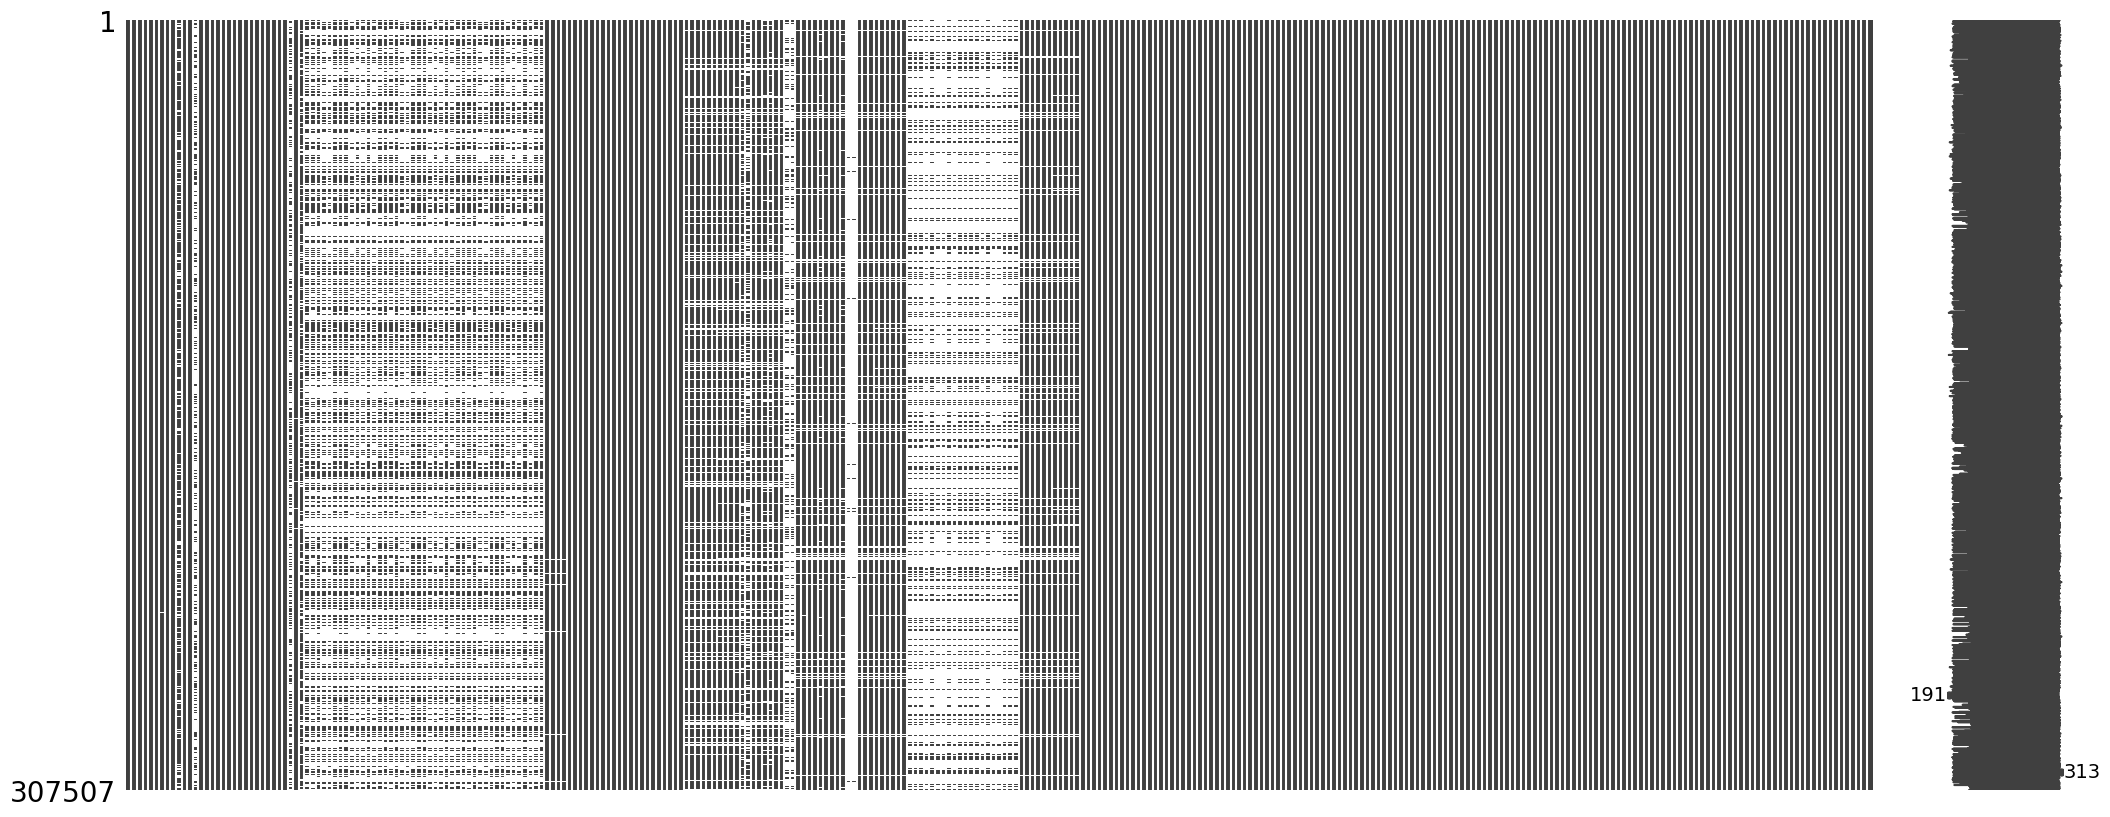

In [ ]:
msno.matrix(data)

In [ ]:
print("Valeurs manquantes dans le train data:", sum(data.isnull().sum()))

Valeurs manquantes dans le train data: 15482292


### Imputation des valeurs manquantes

In [ ]:
# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy="median")
data.iloc[:,:] = imputer.fit_transform(data)

<Axes: >

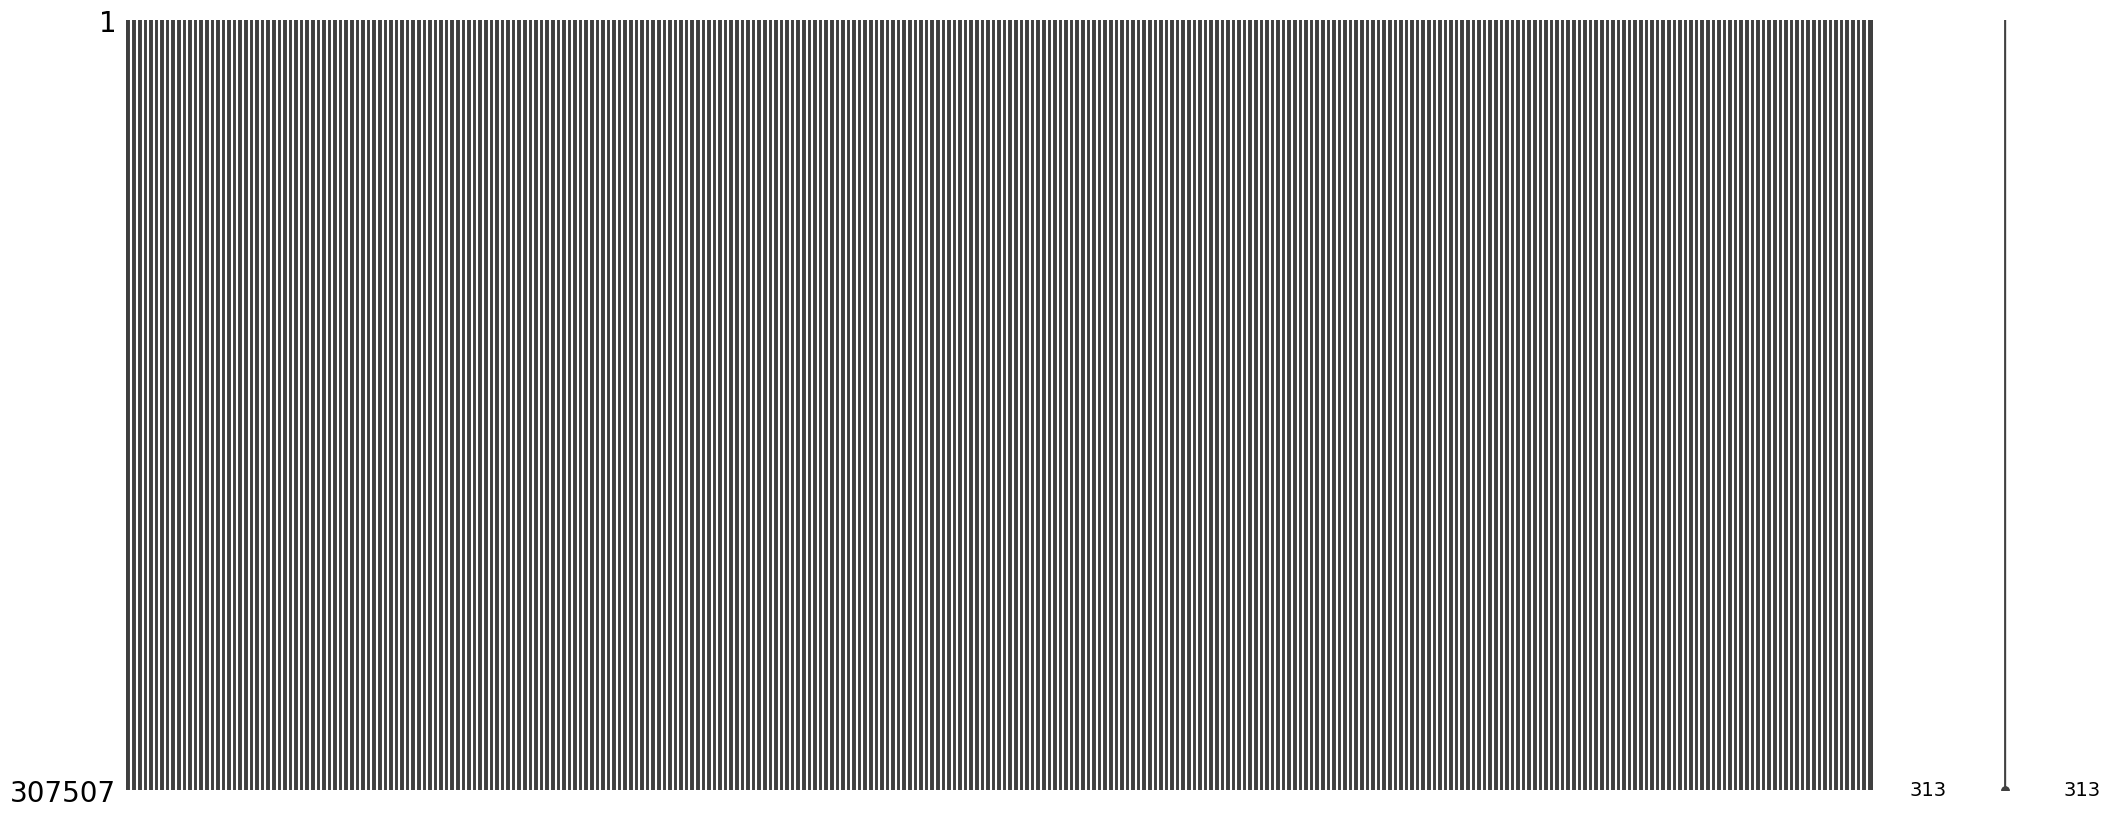

In [ ]:
msno.matrix(data)

In [ ]:
print("Valeurs manquantes dans le train data:", sum(data.isnull().sum()))

Valeurs manquantes dans le train data: 0


In [ ]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307507
Nombre de colonnes : 313
Type des colonnes : 
float64    273
int64       40
Name: count, dtype: int64


In [ ]:
data.head(10)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,0,99000.0,490495.5,27517.5,454500.0,0.035792,-16941,-1588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100009,0,1,171000.0,1560726.0,41301.0,1395000.0,0.035792,-13778,-3130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100010,0,0,360000.0,1530000.0,42075.0,1530000.0,0.003122,-18850,-449.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,0,112500.0,1019610.0,33826.5,913500.0,0.018634,-20099,-1648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,100012,0,0,135000.0,405000.0,20250.0,405000.0,0.019689,-14469,-2019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Normalisation des données
- Les colonnes étant toutes numérique (float64 : 264 et int64 : 44), Nous allons normaliser les données

In [ ]:
# Séparation des données
X = data.drop("TARGET", axis=1)
y = data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77, stratify=y)

# Normalisation de X_train
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Application de la transformation sur X_test
X_test_scaled = scaler.transform(X_test)

- La normalisation des données est une étape dans de nombreux processus d'analyse de données et de machine learning, car elle permet de standardiser les échelles des features du dataset.

In [ ]:
data.head(20)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,202500.000,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003,0,0,270000.000,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004,0,0,67500.000,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.000,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,121500.000,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,0,99000.000,490495.5,27517.5,454500.0,0.035792,-16941,-1588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100009,0,1,171000.000,1560726.0,41301.0,1395000.0,0.035792,-13778,-3130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100010,0,0,360000.000,1530000.0,42075.0,1530000.0,0.003122,-18850,-449.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,0,112500.000,1019610.0,33826.5,913500.0,0.018634,-20099,-1648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,100012,0,0,135000.000,405000.0,20250.0,405000.0,0.019689,-14469,-2019.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 307507
Nombre de colonnes : 313
Type des colonnes : 
float64    273
int64       40
Name: count, dtype: int64


In [ ]:
#data.to_csv("P4_data.csv", index = False)

### Equilibrage de la "TARGET"

In [ ]:
# Recombiner X_train et y_train pour le calcul des corrélations
train_data = pd.concat([X_train, y_train], axis=1)

# Calcul de la matrice de corrélation pour TARGET sur l'ensemble d'entraînement
corr_with_target = train_data.corr()["TARGET"]

# Les 20 corrélations les plus positives
print("Corrélations les plus positives :")
print(corr_with_target.sort_values(ascending=False).head(20))

# Les 20 corrélations les plus négatives
print("Corrélations les plus négatives :")
print(corr_with_target.sort_values(ascending=True).head(20))

Corrélations les plus positives :
TARGET                                               1.000000
PREV_DESK_MEAN_DAYS_CREDIT                           0.079849
DAYS_BIRTH                                           0.077799
PREV_DESK_MEAN_DAYS_CREDIT_UPDATE                    0.064248
DAYS_EMPLOYED                                        0.063479
PREV_APP_MEAN_CC_MEAN_CNT_DRAWINGS_ATM_CURRENT       0.060515
REGION_RATING_CLIENT_W_CITY                          0.060480
REGION_RATING_CLIENT                                 0.058507
NAME_INCOME_TYPE_Working                             0.057365
DAYS_LAST_PHONE_CHANGE                               0.054740
CODE_GENDER_M                                        0.053707
DAYS_ID_PUBLISH                                      0.052024
REG_CITY_NOT_WORK_CITY                               0.051125
PREV_APP_MEAN_CC_MEAN_AMT_BALANCE                    0.051094
PREV_APP_MEAN_CC_MEAN_AMT_TOTAL_RECEIVABLE           0.050742
PREV_APP_MEAN_CC_MEAN_AMT_RECIVABLE 

#### Sélection de 30 variables les plus corrélés avec TARGET

In [ ]:
var_corr = data[["TARGET",
    # Corrélations positives
    "PREV_DESK_MEAN_DAYS_CREDIT",
    "DAYS_BIRTH",
    "NAME_EDUCATION_TYPE_Secondary / secondary special",
    "NAME_INCOME_TYPE_Working",
    "PREV_DESK_MEAN_DAYS_CREDIT_UPDATE",
    "REGION_RATING_CLIENT_W_CITY",
    "REGION_RATING_CLIENT",
    "DAYS_LAST_PHONE_CHANGE",
    "FLAG_DOCUMENT_3",
    "PREV_APP_MEAN_DAYS_DECISION",
    "CODE_GENDER_M",
    "PREV_DESK_MEAN_DAYS_ENDDATE_FACT",
    "DAYS_ID_PUBLISH",
    "PREV_APP_MEAN_CC_MEAN_CNT_DRAWINGS_ATM_CURRENT",
    "OCCUPATION_TYPE_Laborers",

    # Corrélations négatives
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "EXT_SOURCE_1",
    "NAME_EDUCATION_TYPE_Higher education",
    "DAYS_EMPLOYED",
    "EMERGENCYSTATE_MODE_No",
    "ELEVATORS_AVG",
    "ELEVATORS_MEDI",
    "FLOORSMAX_AVG",
    "FLOORSMAX_MEDI",
    "CODE_GENDER_F",
    "ELEVATORS_MODE",
    "FLOORSMAX_MODE",
    "HOUSETYPE_MODE_block of flats",
    "NAME_INCOME_TYPE_Pensioner"
]]

Text(0.5, 1.0, 'Carte thermique de corrélations Var_cor')

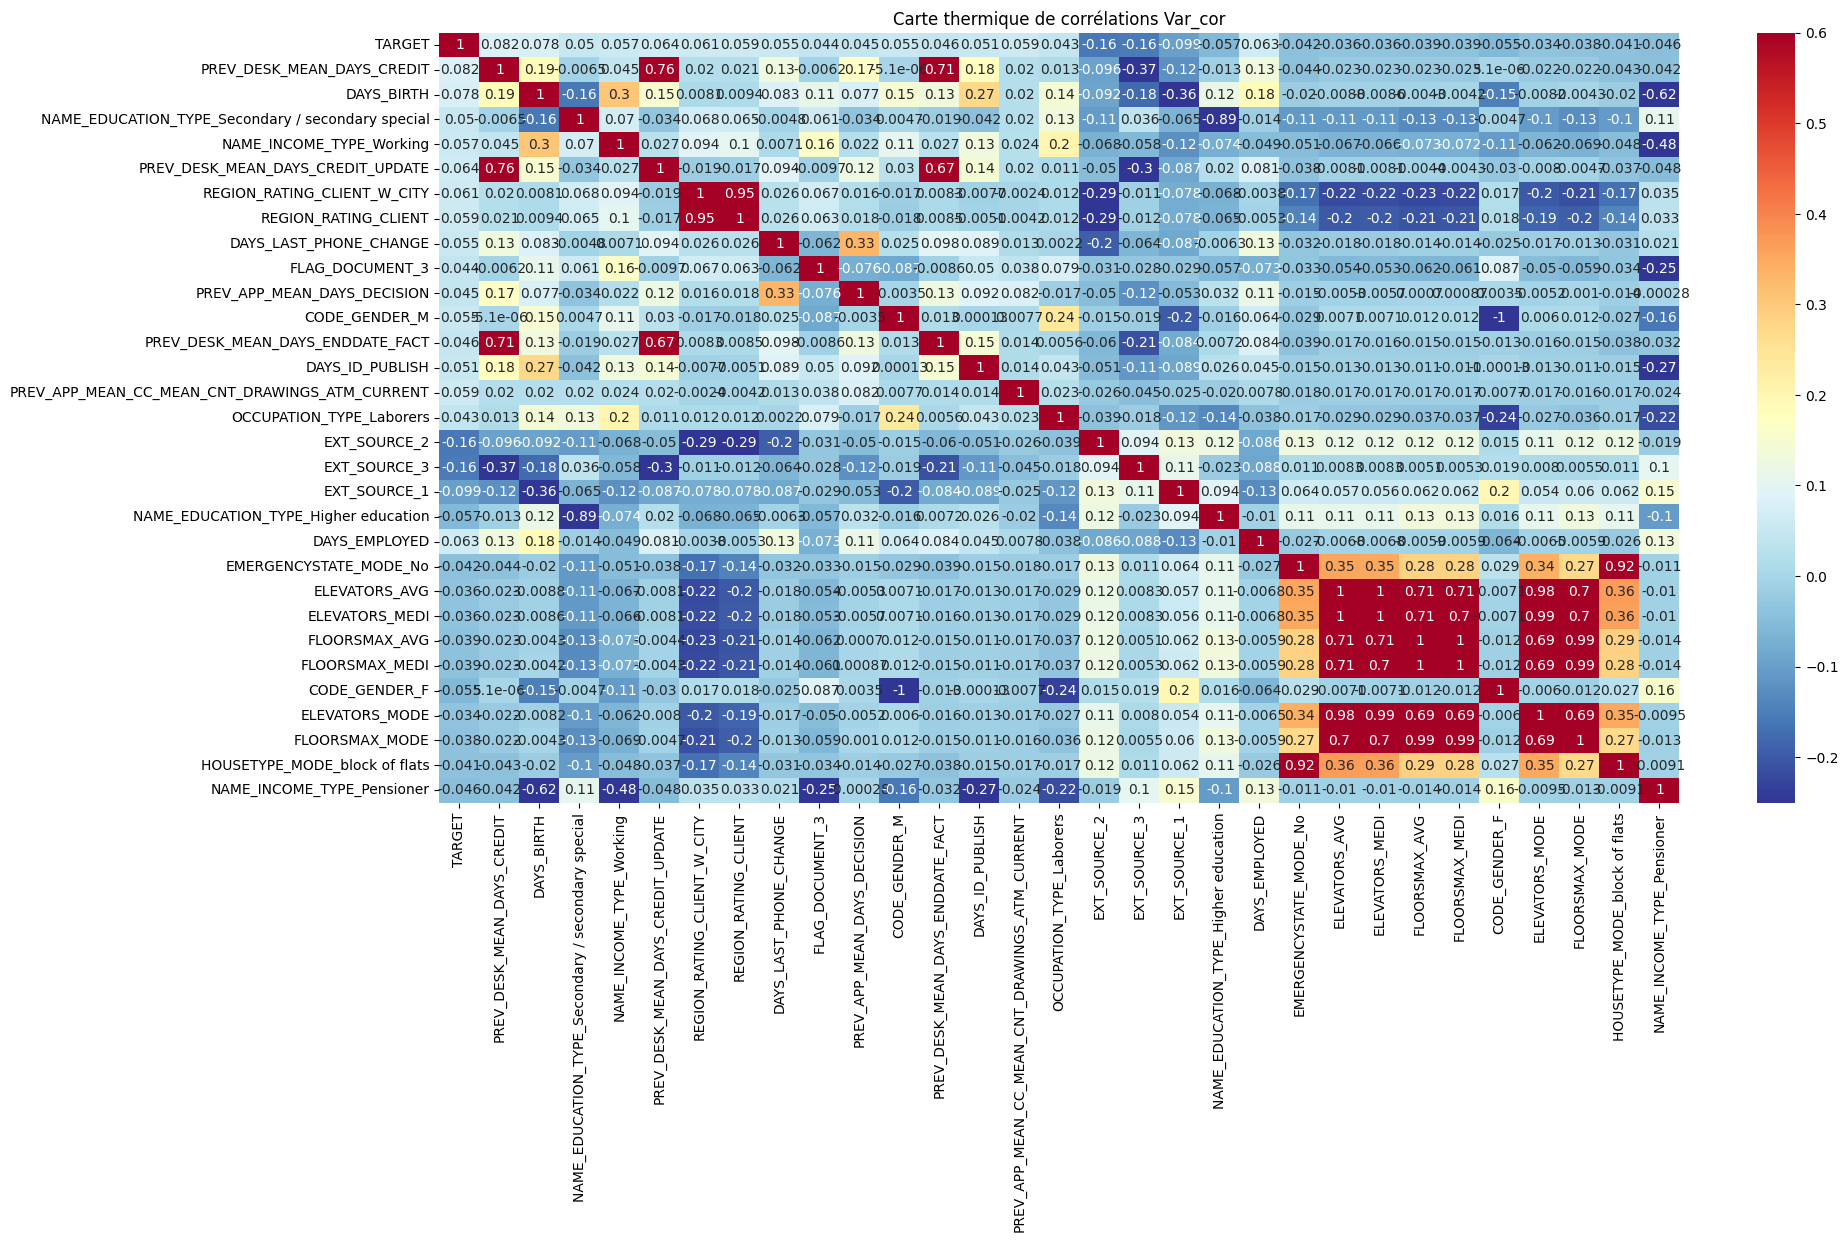

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(var_corr.corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
)
plt.title('Carte thermique de corrélations Var_cor')

En analysant la matrice de corrélation, nous avons identifié des paires de variables qui présentent une forte corrélation (proche de 1 / -1). Cela signifie que lorsqu'une variable augmente, l'autre diminue de façon significative, indiquant une redondance entre elles. Voici les paires les plus redondantes :

1. **PREV_APP_MEAN_CC_MEAN_AMT_TOTAL_RECEIVABLE** / **PREV_APP_MEAN_CC_MEAN_AMT_BALANCE**
2. **PREV_APP_MEAN_CC_MEAN_AMT_RECEIVABLE_PRINCIPAL** / **PREV_APP_MEAN_CC_MEAN_AMT_RECEIVABLE**
3. **ELEVATORS_MEDI** / **FLOORSMAX_AVG**
4. **FLOORSMAX_MODE** / **FLOORSMAX_AVG**

In [ ]:
new_var = var_corr.drop(columns=[
    "FLOORSMAX_AVG",
    "FLOORSMAX_MEDI",
    "FLOORSMAX_MODE",
    "ELEVATORS_AVG",
    "ELEVATORS_MEDI",
    "ELEVATORS_MODE"
])

___
La suppression de ces variables est necéssaire afin d'éviter la multicolinéarité, elle permet d'améliorer les performances des modèles tout en réduisant leurs complexité et elle minimise les risques de surapprentissage.
___

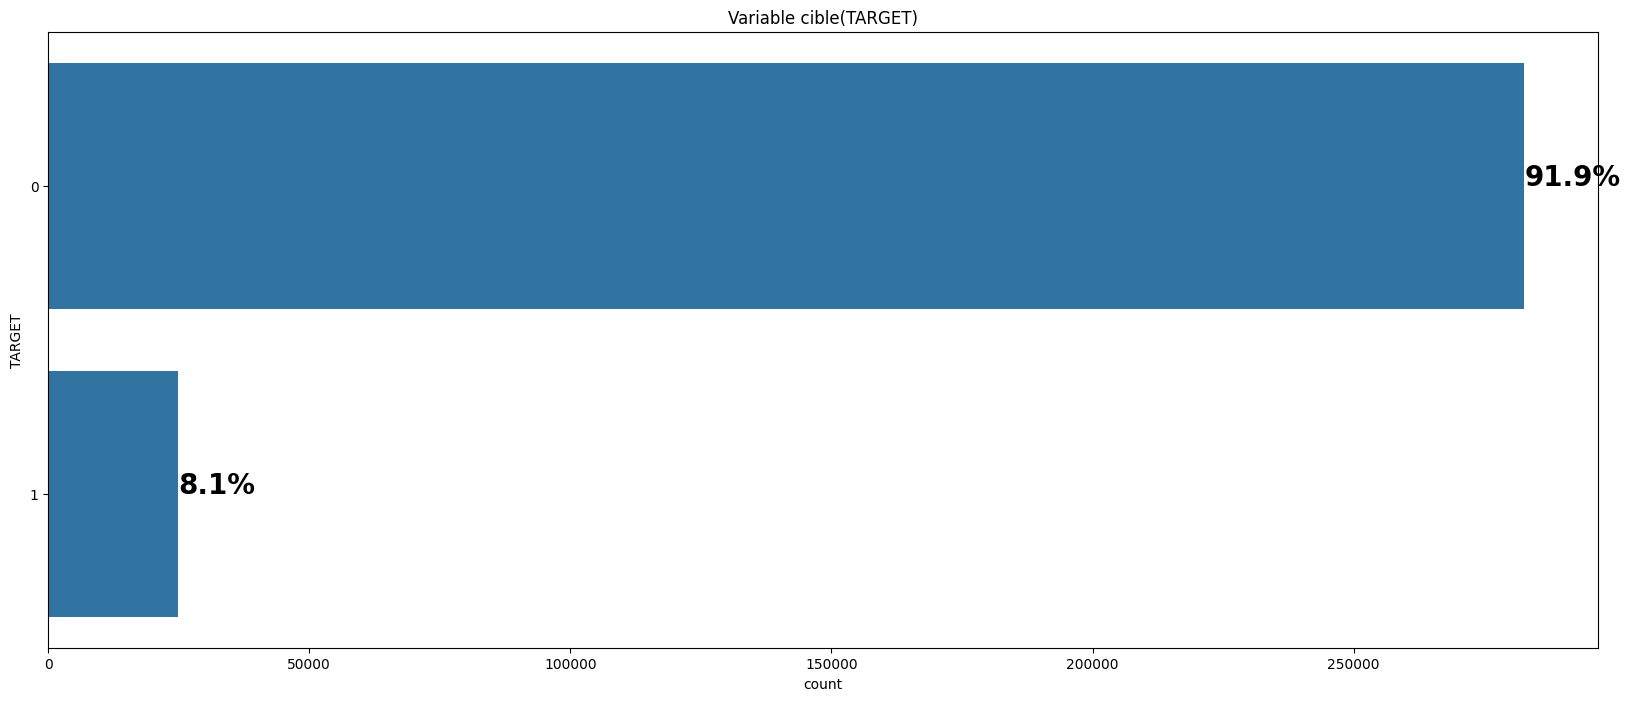

In [ ]:
# Apercu de notre "target" avant équilibrage
plot_graph(new_var,"TARGET","Variable cible(TARGET)")

In [ ]:
# Séparation des features (X) et de la cible (y)
X = new_var.drop("TARGET", axis=1)
y = new_var["TARGET"]

# Définition du modèle
xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.03, random_state=77)

# Création du pipeline avec normalisation, SMOTE et modèle
pipeline = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=77)),
    ('model', xgb_model)
])

# Validation croisée avec StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=77)

# Évaluation des performances avec la métrique ROC AUC
scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='roc_auc')

# Affichage des résultats
print(f"Scores de validation croisée pour chaque fold: {scores}")
print(f"Moyenne des scores de validation croisée : {scores.mean():.4f}")
print(f"Écart-type des scores : {scores.std():.4f}")

Scores de validation croisée pour chaque fold: [0.66792941 0.67620313 0.67543252 0.66402325 0.67623973]
Moyenne des scores de validation croisée : 0.6720
Écart-type des scores : 0.0051


In [ ]:
"""X = data.drop("TARGET", axis=1)
y = data["TARGET"]

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77, stratify=y)

# Application du suréchantillonnage uniquement à l'ensemble d'entraînement
ros = RandomOverSampler(sampling_strategy=1.0, random_state=77)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Affichage des formes avant et après le suréchantillonnage
print(f"Forme avant le suréchantillonnage (ensemble d'entraînement): {X_train.shape}")
print(f"Forme après le suréchantillonnage (ensemble d'entraînement): {X_train_ros.shape}")

# Vérification de la répartition des classes dans les données suréchantillonnées
print("\nSolde des classes prêt remboursé et hors délai dans l'ensemble d'entraînement (%):")
print(y_train_ros.value_counts(normalize=True) * 100)

# Réintégration des données suréchantillonnées dans le DataFrame
data = pd.concat([pd.DataFrame(X_train_ros, columns=X.columns), pd.Series(y_train_ros, name="TARGET")], axis=1)"""

'X = data.drop("TARGET", axis=1)\ny = data["TARGET"]\n\n# Séparation des données en ensemble d\'entraînement et de test\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77, stratify=y)\n\n# Application du suréchantillonnage uniquement à l\'ensemble d\'entraînement\nros = RandomOverSampler(sampling_strategy=1.0, random_state=77)\nX_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)\n\n# Affichage des formes avant et après le suréchantillonnage\nprint(f"Forme avant le suréchantillonnage (ensemble d\'entraînement): {X_train.shape}")\nprint(f"Forme après le suréchantillonnage (ensemble d\'entraînement): {X_train_ros.shape}")\n\n# Vérification de la répartition des classes dans les données suréchantillonnées\nprint("\nSolde des classes prêt remboursé et hors délai dans l\'ensemble d\'entraînement (%):")\nprint(y_train_ros.value_counts(normalize=True) * 100)\n\n# Réintégration des données suréchantillonnées dans le DataFrame\ndata = pd.concat([p

In [ ]:
# Division des données AVANT l'application de SMOTE
X = new_var.drop("TARGET", axis=1)
y = new_var["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77, stratify=y)

# Appliquer SMOTE sur l'ensemble d'entraînement uniquement
smote = SMOTE(random_state=77)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
from collections import Counter

print(f"Proportions avant SMOTE : {Counter(y_train)}")
print(f"Proportions après SMOTE : {Counter(y_train_sm)}")

Proportions avant SMOTE : Counter({0: 226145, 1: 19860})
Proportions après SMOTE : Counter({0: 226145, 1: 226145})


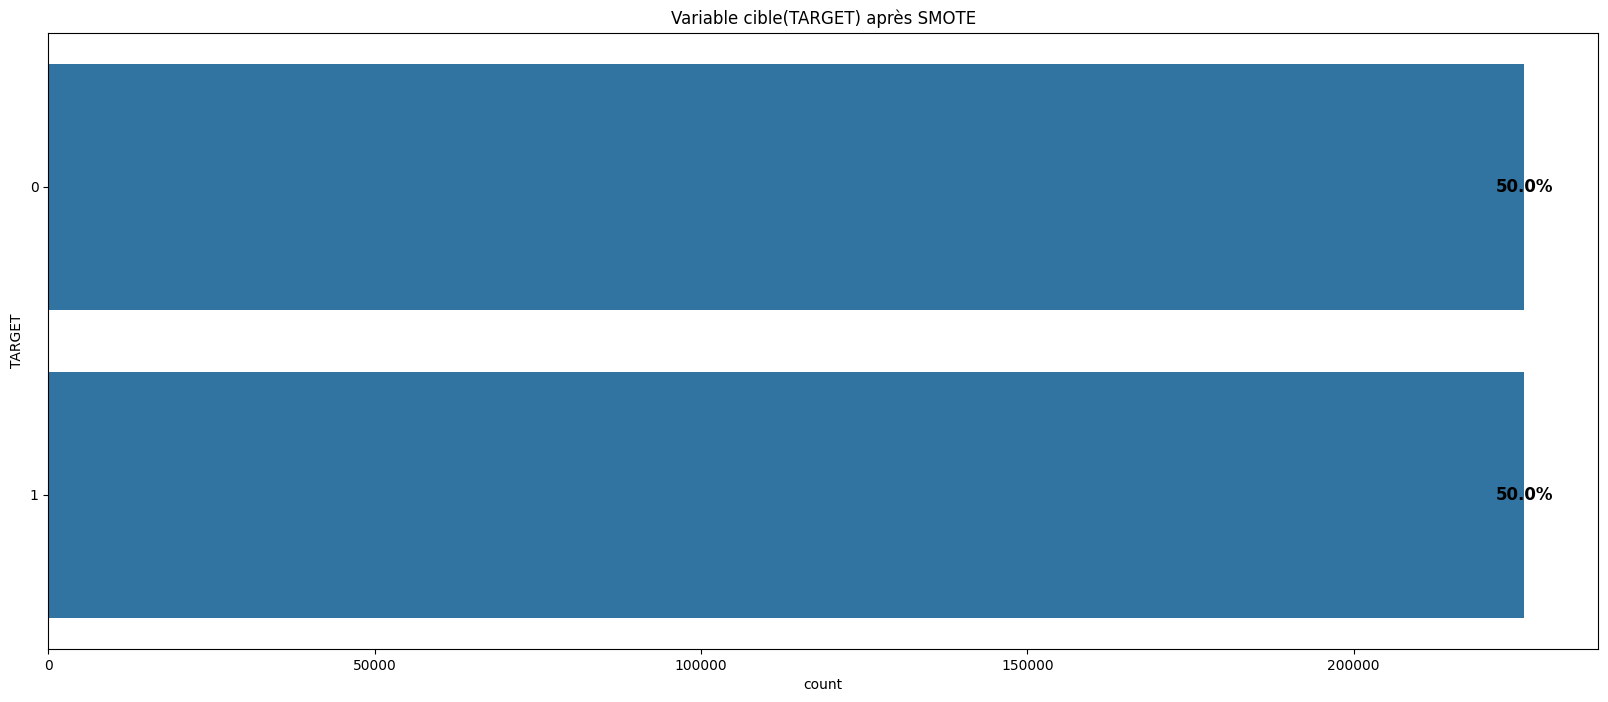

In [ ]:
# Apercu de notre "target" après équilibrage
plot_graph(y_train_sm, "Variable cible(TARGET) après SMOTE")

In [ ]:
new_var

In [ ]:
#new_var.to_csv("P4_new_var.csv", index = False)
#X_train_sm.to_csv("X_train_sm.csv", index = False)
#y_train_sm.to_csv("y_train_sm.csv", index = False)
#X_test.to_csv("X_test.csv", index = False)
#y_test.to_csv("y_test.csv", index = False)